In [1]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from models import *
import time
import re, io, nltk, torch 
from nltk.corpus import stopwords
from numpy import linalg as LA
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.utils.class_weight import compute_class_weight
from gensim import utils, matutils  
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from numpy import linalg as LA
from sklearn.preprocessing import Normalizer
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from scipy.stats import bernoulli
import numpy as np


n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

train =pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/test_semeval_raw.csv")


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    #re.sub(r'([a-z])\1+', r'\1', "user i think that ' s all you loooooove ")
    s= re.sub(r"http\S+", " <html> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    #“
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " <number> ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index_valid[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in Word2Index_valid.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in Word2Index_valid.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
embeddings_index = {}
f = open(os.path.join("glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193514 terminos con sus vectores de embedding.


In [5]:
word_index=dict()
j=1
for frase in train["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

for frase in val["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
for frase in test["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
len(word_index.keys())

7239

In [6]:
not_found=[]
pos_tag_nf=[]
Word2Index={}
Word2Index_valid={}
idx_2_token={}
idx_2_token_valid={}

g_dim=200
emb_matrix = np.zeros((len(word_index.keys())+1, g_dim))  

k=1
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        emb_matrix[i] = vector
        Word2Index[word]=i
        Word2Index_valid[word]=k
        idx_2_token_valid[k]=word
        k+=1
        idx_2_token[i]=word
        
    else:
        Word2Index[word]=i
        idx_2_token[i]=word
        not_found.append(word)
        pos_tag_nf.append(nltk.pos_tag([word])[0][-1])

In [7]:
k

6715

In [8]:
g_dim=200
glove_matrix = np.zeros((k, g_dim))

for word, i in Word2Index_valid.items():
    vector = embeddings_index.get(word)    
    glove_matrix[i] = vector
    
glove_matrix.shape

(6715, 200)

In [9]:
print ("[my_cleaner] \t#Palabras NO encontradas en vocab GLOVE:",len(not_found))
print ("[my_cleaner] \t#Palabras encontradas en vocab GLOVE:",len(word_index.keys())-len(not_found))
print ("Distribución de palabras no encontradas en POS tag:", Counter(pos_tag_nf) )

[my_cleaner] 	#Palabras NO encontradas en vocab GLOVE: 525
[my_cleaner] 	#Palabras encontradas en vocab GLOVE: 6714
Distribución de palabras no encontradas en POS tag: Counter({'NN': 371, 'NNS': 60, 'CD': 46, 'JJ': 15, 'VBN': 12, 'VBG': 11, 'RB': 8, 'VB': 1, 'JJS': 1})


In [10]:
for wd in not_found[:20]:
    print ("[",wd,"] \t\tlema:",lemmatizer.lemmatize(wd), "\tStem:",stemmer.stem(wd), "\tStem snow:", stemmer_sn.stem(wd))

[ 5th ] 		lema: 5th 	Stem: 5th 	Stem snow: 5th
[ krauts ] 		lema: kraut 	Stem: kraut 	Stem snow: kraut
[ +&gt ] 		lema: +&gt 	Stem: +&gt 	Stem snow: +&gt
[ firedoor ] 		lema: firedoor 	Stem: firedoor 	Stem snow: firedoor
[ prayerz ] 		lema: prayerz 	Stem: prayerz 	Stem snow: prayerz
[ in2 ] 		lema: in2 	Stem: in2 	Stem snow: in2
[ 4x ] 		lema: 4x 	Stem: 4x 	Stem snow: 4x
[ darams ] 		lema: darams 	Stem: daram 	Stem snow: daram
[ 7th ] 		lema: 7th 	Stem: 7th 	Stem snow: 7th
[ &amp ] 		lema: &amp 	Stem: &amp 	Stem snow: &amp
[ carsonscottli ] 		lema: carsonscottli 	Stem: carsonscottli 	Stem snow: carsonscott
[ fields' ] 		lema: fields' 	Stem: fields' 	Stem snow: field
[ hamyd ] 		lema: hamyd 	Stem: hamyd 	Stem snow: hamyd
[ 230km ] 		lema: 230km 	Stem: 230km 	Stem snow: 230km
[ defident ] 		lema: defident 	Stem: defid 	Stem snow: defid
[ sydneysiders ] 		lema: sydneysiders 	Stem: sydneysid 	Stem snow: sydneysid
[ snipered ] 		lema: snipered 	Stem: sniper 	Stem snow: sniper
[ ~&gt ] 		lem

In [11]:
#transf = Normalizer().fit(glove_matrix) 
#M_GLOVE_space=transf.transform(glove_matrix)
M_GLOVE_space= glove_matrix

def my_tokenizer(lista):
    encoded_sent=[]
    to_return_ide=[]
    for wd in lista:
        try:               
            to_return_ide.append(Word2Index_valid[wd])
            encoded_sent.append(wd)
        except: 
            continue   
           
    return to_return_ide, encoded_sent

In [12]:
def my_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v/norm

#el peso max es igual a la clase mas grande
def det_samples(df, dict_class, c_weights=None):
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
    for clase in conteos:
        if conteos[clase]==maxi:
            class_maxi=clase
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            weigths=my_normalize(c_weights)
            max_wei=max(weigths)
            class_max= list(weigths).index(max_wei)
            str_class=dict_class[class_max]
            samples_max=conteos[str_class]
            
            clase=0
            for peso in weigths:
                k=dict_class[clase]
                if peso == max_wei:
                    aumentos[k]= int(samples_max-conteos[k])
                    #print ("aumentos[k]", aumentos[k], 'sampples min', samples_max, 'conteos[clase]', conteos[clase])
                else:
                    futuro=(samples_max/max_wei)*peso
                    aumentos[k]=int(futuro-conteos[k])
                    #print ("aumentos[k] para pesos no minimos ", aumentos[k], "futuro", futuro, "actual", conteos[k])
                clase+=1
            return aumentos
        except:
            print ("No se ha especificado el vector de pesos par balance de datos")
            
            
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1]))   
  
def re_generar(muestra, tags_all, tag, prob):
    sent, indices, tags = just_tag_word(muestra, tags_all, tag)
    noise_mask = bernoulli.rvs(prob, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    idx_to_orig=len(sent)
    return  to_replace , indix, tagx, idx_to_orig

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def just_tag_word(sentence, tags_all, tag):
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if tags_all[i] not in tag:
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def all_tag_word(sentence):    
    n_sentence=[]
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            continue
        else:
            n_sentence.append(wd)    
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)
    
def all_tag_word2(sentence):
    n_sentence=[]
    for wd in sentence:
        if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
            continue
        else:
            n_sentence.append(wd)
    return np.asarray(n_sentence)
        
def check_word(token, tag, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in vocabulary[clase]:
            return True
        else: 
            return False

def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag:
            return True
        else: 
            return False
        
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    #print ("Tags de pos/neg:", lista_tag)
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags:
            keep.append(word)
    return keep
            
def my_most_similar_cosmul(space, M_BERT_space, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    #if negative is None:
    #    negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        Word2Index_valid[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]    
    positive = [M_BERT_space[idx] for idx in ids_pos]  #space de vocab
    
    if negative is None:
        negative = []
    else: 
        #print ("\n\nSE SOLICITAN NEGATIVOS\n\n")
        ids_nega= [
            Word2Index_valid[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
            for word in negative
        ]
        negative = [M_BERT_space[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]
    
    #pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas


def find_positive(lista, target, id_target, bias, window=4):
    to_return=[target]
    to_return=to_return*int(bias)
    positive_temp=find_window(lista, target, id_target, window=window)
    to_return+=positive_temp
    
    return to_return
                  

def find_window(lista, target, id_target, window=4):  #wind debe ser par   
    to_return=[]
    sub_w=int(window/2)
    
    if id_target >= sub_w and id_target + sub_w < len(lista):
        atras=lista[id_target-sub_w:id_target]
        adelante=lista[id_target+1:id_target+1+sub_w]
        
    elif id_target  < sub_w:
        atras=lista[:id_target]
        adelante=lista[id_target+1:id_target+sub_w+1]
        
    elif id_target + sub_w >= len(lista): 
        atras=lista[id_target-sub_w:id_target]
        adelante= lista[id_target+1:]
        
    to_return+=atras
    to_return+=adelante
    return to_return


def find_negative(target, not_sent, window=4):
    cleaned = cleaner(not_sent)[1]
    cleaned_ide, cleaned = my_tokenizer(cleaned)
    ide = cleaned.index(target)
    wind_neg=find_window(list(cleaned), target, ide, window=window)
   
    return wind_neg


def sample_neg_class(cl):
    if type(cl) != list:
        cl = [cl]
    aux = list(d_lab.keys())
    for value in cl:
        aux.remove(value)
    samp_neg = np.random.choice(aux)
    
    used_classes = cl
    used_classes.append(samp_neg)
    return samp_neg, used_classes

def check_special(lista):
    exceptions=['[CLS]', '[SEP]', '[MASK]']
    to_return=[]
    for item in lista:  #es una tupla
        if item[0] not in exceptions: 
            to_return.append(item[0])
        else:
            continue
    return to_return

def choose_replace(candidatos, ide, target):
    candidatos=check_special(candidatos)
    try:
        candidatos.remove(target)
    except:
        pass
    
    elem=np.random.choice(candidatos)
    return (elem, ide)
        

def aumentar_clase(clase, num_ejem, tags_all, prob, TOPN):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['Tw_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    pre_ide, pre_str = my_tokenizer(cleaner(muestra)[1])
                    #print ("pre_str", pre_str, type(pre_str), len(pre_str))
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre_str]
                    #print (tags_pre)
                    terms, indxs, tagx, tope_replace= re_generar(pre_str, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):                           
                            mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_pos[tag])
                            mask_words = np.concatenate((np.asarray([False]), mask_words))
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= M_GLOVE_space[mask_words] #vocab de clase y tag
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(pre_str, term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4) 
                                    valid_neg=check_valid(neg, tags_all)

                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue
                                    #pass

                                best, dists_best = my_most_similar_cosmul(space, M_GLOVE_space, 0.0, positive=valid_pos, negative=valid_neg, topn=TOPN)
                                #best, dists_best = my_most_similar_cosmul(space, M_BERT_space, 0.0, positive=valid_pos, negative=None, topn=TOPN)

                                todo_words = {
                                    Word2Index_valid[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in Word2Index_valid
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token_valid[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:TOPN] #+2
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre_str)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre_str[i])
                                except: 
                                    nueva_sent.append(pre_str[i])
                       
                            totales+=cont_new
                            new_sample.append([contador, nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre_str)
                            contador+=1
                            
                            #"""
                            if len(new_sample)<10:
                                print ("Sentencia original:\t", pre_str)
                                print ("Sentencia final:" , label)
                                print (nueva_sent)
                                print ("")
                                #print ("")
                            #"""                              

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre_idx, pre_stx = my_tokenizer(cleaner(muestra)[1])
                        pre=np.asarray(pre_stx)
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['Tw_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre_idx, pre_stx = my_tokenizer(cleaner(muestra)[1])
            pre=np.asarray(pre_stx)
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    return new_sample, dict_resumen


def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)"""
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [13]:
tr_s=train.loc[train['Label']=='support']
tr_d=train.loc[train['Label']=='denying']
tr_q=train.loc[train['Label']=='questioning']
tr_c=train.loc[train['Label']=='commenting']
keys=['support', 'denying', 'questioning', 'commenting']

dict_vocab={}
for key in keys: 
    tr_k=train.loc[train['Label']==key]
    tr_k=tr_k['Tweet'].values    
    trs_k=[]
    for tw in tr_k:
        encoded = cleaner(tw)[1]
        apen=[]
        for wd in encoded:
            try: 
                h=Word2Index_valid[wd]
                apen.append(wd)
            except: 
                continue
        
        #trs_k+=list(set(encoded))
        trs_k+=apen
    dict_vocab[key]=list(set(trs_k ))
    print ("#terms ",key,":",len(dict_vocab[key]))
      


#terms  support : 2018
#terms  denying : 1368
#terms  questioning : 1149
#terms  commenting : 4672


In [14]:
vocabulary=dict_vocab
dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(cleaner(muestra)[1])
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)

In [15]:
idx_2_token_valid

{1: '<user>',
 2: 'clarified',
 3: 'that',
 4: 'earlier',
 5: '.',
 6: 'cheers',
 7: 'i',
 8: 'think',
 9: "'",
 10: 's',
 11: 'all',
 12: 'you',
 13: 'got',
 14: 'time',
 15: 'for',
 16: 'absolutely',
 17: 'disgusting',
 18: '!',
 19: 'using',
 20: 'someone',
 21: 'terrifying',
 22: 'murder',
 23: 'own',
 24: 'gain',
 25: 'what',
 26: 'about',
 27: 'their',
 28: 'family',
 29: '?',
 30: 'some',
 31: 'good',
 32: 'news',
 33: 'any',
 34: 'chance',
 35: 'being',
 36: 'said',
 37: 'fear',
 38: 'of',
 39: 'retribution',
 40: 'how',
 41: 'stupid',
 42: '<html>',
 43: 'lol',
 44: '<hashtag>',
 45: '“',
 46: ':',
 47: 'photos',
 48: 'alleged',
 49: 'robbery',
 50: 'involving',
 51: 'michael',
 52: 'brown',
 53: 'in',
 54: 'via',
 55: 'police',
 56: '<number>',
 57: ',',
 58: 'beat',
 59: 'a',
 60: 'man',
 61: 'and',
 62: 'charged',
 63: 'him',
 64: 'bleeding',
 65: 'on',
 66: 'them',
 67: 'bloods',
 68: 'pain',
 69: 'to',
 70: 'get',
 71: 'out',
 72: 'ta',
 73: 'trying',
 74: 'one',
 75: 'to

In [15]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']

In [17]:
len(idx_2_token_valid)

6714

In [18]:
d_pos= dict()
for tag in tags:
    d_pos[tag]= [check_tag(k, tag) for k in idx_2_token_valid.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token_valid.values()]

In [16]:
MAX_LEN=37

## Armar Train-Val-Test

In [20]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 200))
j=0
for in_id in input_ids:
    x_train[j]=M_GLOVE_space[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]


In [17]:
ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 200))
i=0
for in_id in input_ids_val:
    x_val[i]=M_GLOVE_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 200))
i=0
for in_id in input_ids_test:
    x_test[i]=M_GLOVE_space[in_id]
    i+=1

x_test.shape

(1021, 37, 200)

In [17]:
input_ids_val.shape

(281, 37)

In [23]:
class_weights

array([1., 1., 1., 1.])

embedding_vector=200
    embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                 input_length=max_input_lenght,trainable=False)

model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
    history = model.fit(X_train, y_train,batch_size=32,epochs=20,verbose=1,validation_data=(X_val_ig,y_val))


In [24]:
#input max_input_lenght, embedding_matrix

class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

from modelsCIARP import *

cnn1=create_ccn1(37, M_GLOVE_space)

trained =train_model(cnn1, input_ids, y_train, input_ids_val, y_val, class_weights, e=20, BS=32, verb=1, focal=True)

## Glove sin aum_ sin pesos

In [24]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/cnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.0/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)



Entrenando exec  1 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy sobre Test cnn1 : 0.7708129285014691
F1-score None sobre Test cnn1 : [0.04651163 0.09195402 0.61463415 0.86298077]
F1-score macro sobre Test cnn1 : 0.4040201416169288

Accuracy sobre Test cnn2 : 0.761998041136141
F1-score None sobre Test cnn2 : [0.         0.         0.16666667 0.86389201]
F1-score macro sobre Test cnn2 : 0.25763967004124483

Accuracy sobre Test rnn1 : 0.6709108716944172
F1-score None sobre Test rnn1 : [0.16       0.14035088 0.50273224 0.79973992]
F1-score macro sobre Test rnn1 : 0.4007057599016835

Accuracy sobre Test rnn2 : 0.67384916748286
F1-score None sobre Test rnn2 : [0.0754717  0.18579235 0.43       0.80360592]
F1-score macro sobre Test rnn2 : 0.3737174929645033

Accuracy sobre Test rnn3 : 0.7463271302644466
F1-score 

In [25]:
#20-20-10-20-10
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.0285475  0.04014881 0.49514847 0.8647201 ]
(0.0) app1 F1-score promedio para cnn2 : [0.01059649 0.         0.356279   0.86766588]
(0.0) app1 F1-score promedio para rnn1 : [0.12536733 0.02807018 0.49263105 0.83989249]
(0.0) app1 F1-score promedio para rnn2 : [0.11838721 0.2002865  0.44072322 0.80897672]
(0.0) app1 F1-score promedio para rnn3 : [0.15886677 0.01025641 0.57531545 0.85003369]

(0.0) app1 F1-score macro promedio para cnn1 : 0.3571412193169204 desvest:  0.03470335175978196
(0.0) app1 F1-score macro promedio para cnn2 : 0.30863534462089304 desvest:  0.031279398880641726
(0.0) app1 F1-score macro promedio para rnn1 : 0.37149026164412446 desvest:  0.020799165367132937
(0.0) app1 F1-score macro promedio para rnn2 : 0.3920934153165385 desvest:  0.026756134874535122
(0.0) app1 F1-score macro promedio para rnn3 : 0.3986180778465578 desvest:  0.027383708347398394

(0.0) app1 Accuracy promedio para cnn1 : 0.7698334965719882
(0.0) app1 Accura

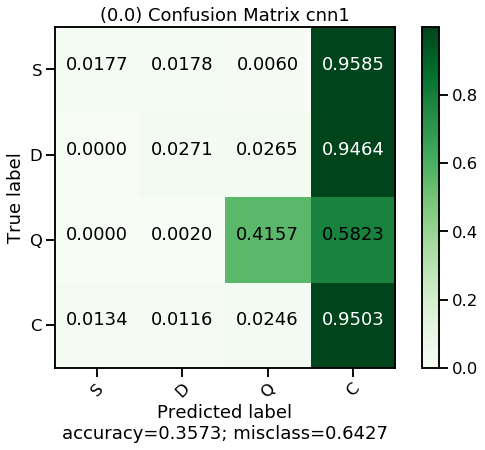

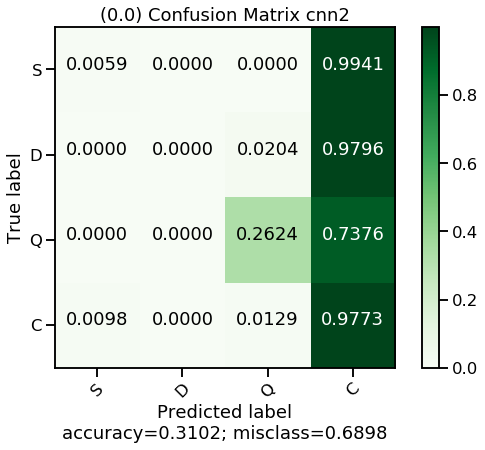

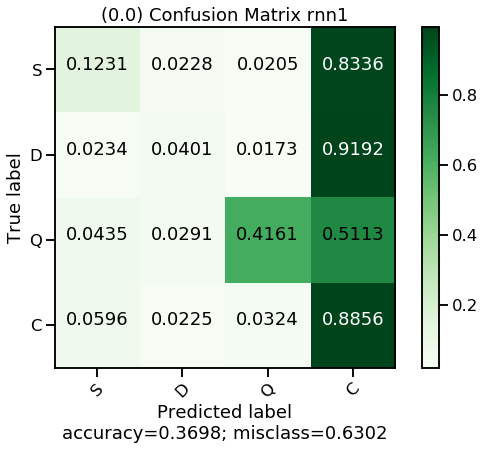

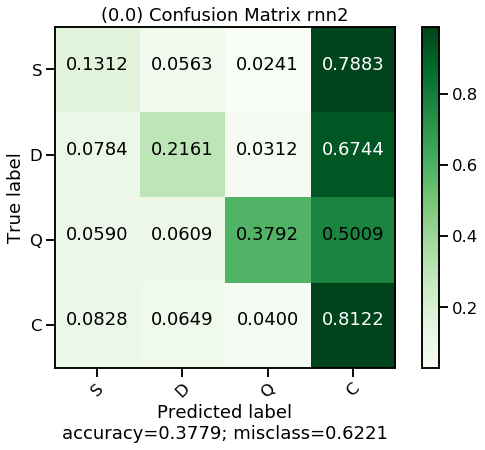

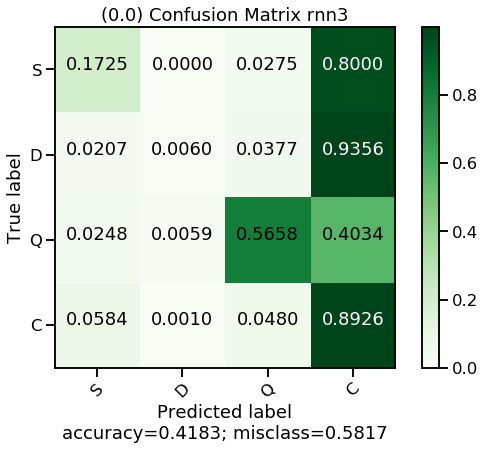

In [26]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0) Confusion Matrix "+str(key), cmap='Greens')

## Sin aumento Con CW

In [27]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]


In [28]:

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/cnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)



Entrenando exec  1 


Accuracy sobre Test cnn1 : 0.6611165523996082
F1-score None sobre Test cnn1 : [0.16949153 0.16       0.6184739  0.77899045]
F1-score macro sobre Test cnn1 : 0.4317389678026742

Accuracy sobre Test cnn2 : 0.6895200783545543
F1-score None sobre Test cnn2 : [0.0733945  0.20320856 0.63114754 0.80426099]
F1-score macro sobre Test cnn2 : 0.42800289447476153

Accuracy sobre Test rnn1 : 0.42115572967678744
F1-score None sobre Test rnn1 : [0.07619048 0.17445483 0.39587629 0.53404067]
F1-score macro sobre Test rnn1 : 0.29514056637060315

Accuracy sobre Test rnn2 : 0.6483839373163565
F1-score None sobre Test rnn2 : [0.12060302 0.18292683 0.44578313 0.79048249]
F1-score macro sobre Test rnn2 : 0.38494886550066826

Accuracy sobre Test rnn3 : 0.2859941234084231
F1-score None sobre Test rnn3 : [0.07407407 0.17974322 0.61702128 0.2965368 ]
F1-score macro sobre Test rnn3 : 0.2918438427930946

Entrenando exec  2 


Accuracy sobre Test cnn1 : 0.6307541625857003
F1-score None sobre 

In [29]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.0_cw) F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.0_cw) F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.0_cw) Accuracy promedio para",key,":" ,temp/5)

(0.0_cw) F1-score promedio para cnn1 : [0.08619724 0.22390738 0.60065053 0.77333519]
(0.0_cw) F1-score promedio para cnn2 : [0.07666074 0.23669411 0.6259108  0.74228837]
(0.0_cw) F1-score promedio para rnn1 : [0.1326551  0.20893135 0.48741064 0.56226005]
(0.0_cw) F1-score promedio para rnn2 : [0.13431767 0.2323876  0.45265668 0.7487537 ]
(0.0_cw) F1-score promedio para rnn3 : [0.15797311 0.21850123 0.51348219 0.54023339]

(0.0_cw) F1-score macro promedio para cnn1 : 0.42102258295541634 desvest:  0.00676118565350678
(0.0_cw) F1-score macro promedio para cnn2 : 0.42038850465009087 desvest:  0.03699829757666369
(0.0_cw) F1-score macro promedio para rnn1 : 0.3478142843234548 desvest:  0.0331177796863011
(0.0_cw) F1-score macro promedio para rnn2 : 0.3920289131888121 desvest:  0.023313931917373173
(0.0_cw) F1-score macro promedio para rnn3 : 0.3575474801204621 desvest:  0.036806898768809104

(0.0_cw) Accuracy promedio para cnn1 : 0.6528893241919687
(0.0_cw) Accuracy promedio para cnn2 : 0.6

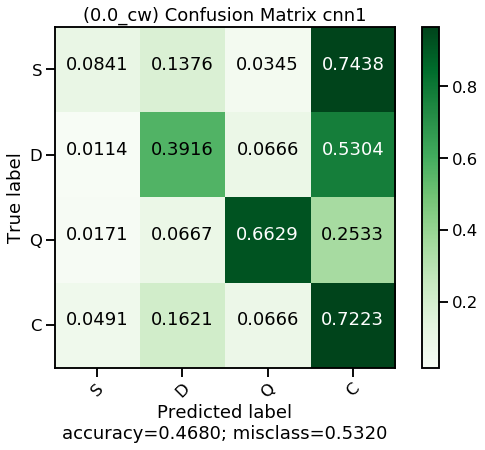

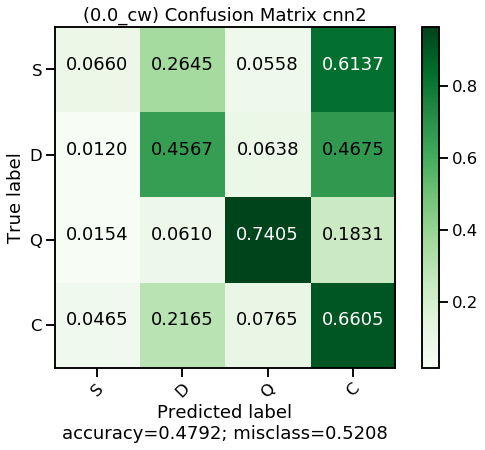

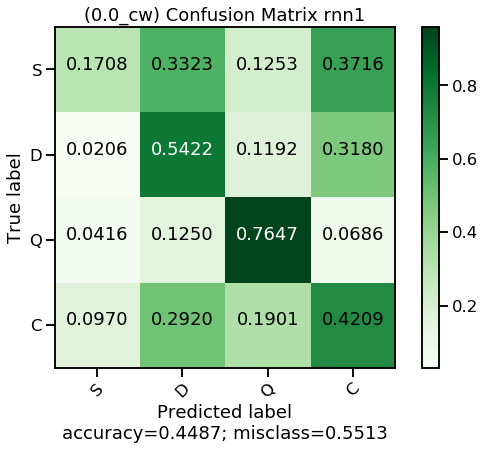

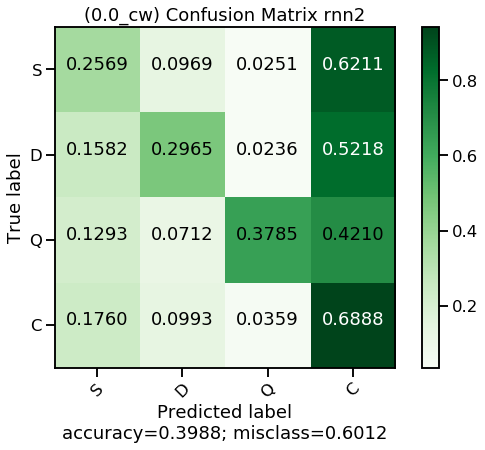

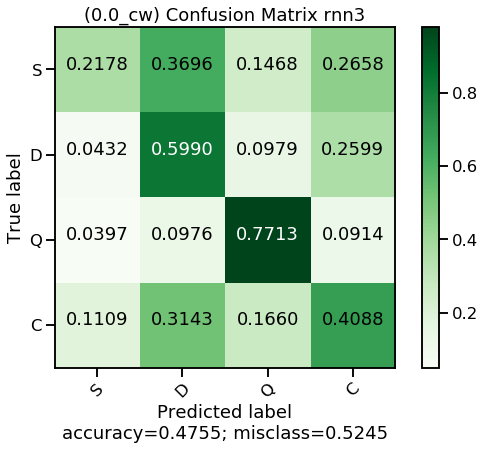

In [30]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0_cw) Confusion Matrix "+str(key), cmap='Greens')

In [31]:
class_weights

array([1.25980975, 3.18168168, 3.21060606, 0.38752743])

In [32]:
"Comparar con ciarp"

'Comparar con ciarp'

# Aumento de datos 

### 0.15

In [22]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob,"\t\tEjecución",i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15 		Ejecución 1
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'were', 'for', 'evil', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<user>', '<user>', 'how', 'stupid', '<html>']
Sentencia final: 2
['<user>', '<user>', '<user>', 'how', 'old', '<html>']

Sentencia original:	 ['<user>', 'absolutely', '!', '<user>', '<user>', '<user>']
Sentencia final: 2
['<user>', 'absolutely', '!', 'rt', '<user>', '<user>']

Sentencia original:	 ['<user>', '<user>', '<user>', '<user>', 'ah', 'true', '.', 'problem', 'now', 'is', 'we', "'", 'll', 'pro

# terms modificados promedio 1.8488129945855893 términos por sentencia
Largo de sentencia promedio 19.566430653894212 términos por sentencia
para esta ejecución se debiesen reemplazar 5066  de 34105 terminos
Resumen de modificaciones: {'VBZ': 156, 'NN': 2909, 'VB': 241, 'VBN': 122, 'VBD': 117, 'NNS': 353, 'VBG': 168, 'JJS': 5, 'JJ': 307, 'JJR': 6, 'VBP': 55}
Este proceso tomó 15.544309139251709 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15 		Ejecución 2
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['rt', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<user>

# terms modificados promedio 1.8546438983756768 términos por sentencia
Largo de sentencia promedio 19.52811328613078 términos por sentencia
para esta ejecución se debiesen reemplazar 5124  de 34471 terminos
Resumen de modificaciones: {'VBZ': 175, 'NN': 2865, 'JJ': 300, 'NNS': 375, 'VBG': 189, 'VBP': 73, 'VBN': 106, 'VB': 221, 'VBD': 134, 'JJS': 6, 'JJR': 9}
Este proceso tomó 15.390503406524658 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15 		Ejecución 3
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['<user>', 'rt', 'any', 'chance', 'that', "'", 's', 'going', 'got', 'for', 'fear', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<user>',

# terms modificados promedio 1.857975843398584 términos por sentencia
Largo de sentencia promedio 19.52478134110787 términos por sentencia
para esta ejecución se debiesen reemplazar 5108  de 33323 terminos
Resumen de modificaciones: {'NN': 2901, 'VBN': 131, 'VBG': 176, 'NNS': 366, 'VBD': 126, 'VB': 199, 'JJ': 297, 'VBZ': 178, 'VBP': 71, 'JJS': 4, 'JJR': 12}
Este proceso tomó 15.680405616760254 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15 		Ejecución 4
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['<user>', '<user>', 'any', 'chance', 'that', "'", 'lol', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<

# terms modificados promedio 1.800499791753436 términos por sentencia
Largo de sentencia promedio 19.61765930862141 términos por sentencia
para esta ejecución se debiesen reemplazar 4947  de 34147 terminos
Resumen de modificaciones: {'NN': 2766, 'VB': 239, 'VBZ': 157, 'NNS': 373, 'JJ': 312, 'VBG': 169, 'VBN': 121, 'VBD': 113, 'VBP': 55, 'JJS': 7, 'JJR': 11}
Este proceso tomó 15.130370855331421 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15 		Ejecución 5
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['rt', '<user>', 'any', 'chance', 'that', "'", 'think', 'fucking', 'said', 'for', 'evil', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<

# terms modificados promedio 1.8525614327363598 términos por sentencia
Largo de sentencia promedio 19.49645980841316 términos por sentencia
para esta ejecución se debiesen reemplazar 5123  de 33890 terminos
Resumen de modificaciones: {'JJ': 310, 'NN': 2884, 'VB': 231, 'VBN': 105, 'VBG': 179, 'VBZ': 173, 'VBD': 122, 'VBP': 60, 'NNS': 366, 'JJR': 10, 'JJS': 8}
Este proceso tomó 15.299363374710083 seg


In [23]:
M_GLOVE_space.shape

(6715, 200)

In [24]:
prob= 0.5
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob,"\t\tEjecución",i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 1
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['clarification', '<user>', 'done', 'that', 'earlier', '.', 'cheers']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['rt', 'possibility', 'any', 'chance', 'that', "'", 'think', 'saying', 'said', 'for', 'fear', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<user>', '<user>', 'how', 'stupid', '<html>']
Sentencia final: 2
['<user>', '<user>', 'rt', 'how', 'stupid', 'irrelevant']

Sentencia original:	 ['<user>', 'absolutely', '!', '<user>', '<user>', '<user>']
Sentencia final

# terms modificados promedio 4.426072469804248 términos por sentencia
Largo de sentencia promedio 17.99750104123282 términos por sentencia
para esta ejecución se debiesen reemplazar 12195  de 24540 terminos
Resumen de modificaciones: {'NN': 6902, 'JJ': 737, 'VBZ': 417, 'VBD': 303, 'VB': 515, 'VBN': 288, 'NNS': 886, 'VBG': 402, 'VBP': 149, 'JJR': 17, 'JJS': 11}
Este proceso tomó 25.038845539093018 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 2
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['<user>', 'rt', 'done', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']

# terms modificados promedio 4.436068304872969 términos por sentencia
Largo de sentencia promedio 18.016659725114536 términos por sentencia
para esta ejecución se debiesen reemplazar 12179  de 24560 terminos
Resumen de modificaciones: {'NN': 6968, 'VBG': 418, 'VBD': 277, 'VB': 514, 'JJ': 728, 'NNS': 871, 'VBZ': 394, 'VBN': 294, 'VBP': 151, 'JJS': 14, 'JJR': 22}
Este proceso tomó 24.972932815551758 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 3
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['<user>', 'rt', 'clarified', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution'

# terms modificados promedio 4.467721782590587 términos por sentencia
Largo de sentencia promedio 18.07496876301541 términos por sentencia
para esta ejecución se debiesen reemplazar 12358  de 24685 terminos
Resumen de modificaciones: {'VBG': 425, 'NN': 6960, 'VBZ': 398, 'VBD': 300, 'JJ': 734, 'VB': 515, 'VBN': 298, 'NNS': 906, 'VBP': 155, 'JJS': 18, 'JJR': 18}
Este proceso tomó 26.155316591262817 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 4
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['clarification', 'rt', 'clarified', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retrib

# terms modificados promedio 4.463556851311953 términos por sentencia
Largo de sentencia promedio 18.09204498125781 términos por sentencia
para esta ejecución se debiesen reemplazar 12343  de 24723 terminos
Resumen de modificaciones: {'NN': 6861, 'VBG': 454, 'JJ': 736, 'VBZ': 393, 'VBD': 300, 'VBN': 287, 'NNS': 949, 'VB': 547, 'VBP': 153, 'JJR': 17, 'JJS': 20}
Este proceso tomó 25.34729504585266 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 5
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['<user>', '<user>', 'done', 'that', 'earlier', '.', 'cheers']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?

# terms modificados promedio 4.477717617659309 términos por sentencia
Largo de sentencia promedio 18.107455226988755 términos por sentencia
para esta ejecución se debiesen reemplazar 12355  de 24723 terminos
Resumen de modificaciones: {'NN': 6933, 'JJ': 725, 'VB': 531, 'VBD': 302, 'VBZ': 418, 'NNS': 941, 'VBG': 432, 'VBN': 300, 'JJS': 13, 'VBP': 141, 'JJR': 15}
Este proceso tomó 26.179237604141235 seg


In [25]:
prob= 0.85
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob,"\t\tEjecución",i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 1
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['<user>', 'rt', 'clarified', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']
Sentencia final: 2
['rt', 'enter', 'any', 'mal', 'that', "'", 'cool', 'going', 'said', 'for', 'evil', 'of', 'retribution', '?']

Sentencia original:	 ['<user>', '<user>', '<user>', 'how', 'stupid', '<html>']
Sentencia final: 2
['rt', 'rt', 'rt', 'how', 'wrong', '<html>']

Sentencia original:	 ['<user>', '<user>', '<user>', '<html>']
Sentencia final: 2
['rt', 'rt', '<user>', 'rt']

Sentencia ori

# terms modificados promedio 7.353602665556019 términos por sentencia
Largo de sentencia promedio 17.666389004581426 términos por sentencia
para esta ejecución se debiesen reemplazar 20334  de 23816 terminos
Resumen de modificaciones: {'NN': 11437, 'JJ': 1209, 'VBZ': 653, 'VB': 882, 'VBD': 507, 'VBN': 477, 'NNS': 1494, 'VBG': 696, 'VBP': 245, 'JJS': 24, 'JJR': 32}
Este proceso tomó 37.52704834938049 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 2
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['lol', 'rt', 'done', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?'

# terms modificados promedio 7.337359433569346 términos por sentencia
Largo de sentencia promedio 17.645564348188255 términos por sentencia
para esta ejecución se debiesen reemplazar 20254  de 23775 terminos
Resumen de modificaciones: {'NN': 11395, 'JJ': 1210, 'VBZ': 661, 'VBD': 511, 'VB': 878, 'VBN': 477, 'NNS': 1490, 'VBG': 708, 'VBP': 233, 'JJS': 24, 'JJR': 30}
Este proceso tomó 40.393609046936035 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 3
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['glad', 'clarification', 'done', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retr

# terms modificados promedio 7.2969596001665975 términos por sentencia
Largo de sentencia promedio 17.64139941690962 términos por sentencia
para esta ejecución se debiesen reemplazar 20128  de 23775 terminos
Resumen de modificaciones: {'NN': 11371, 'VBG': 705, 'JJ': 1198, 'VBZ': 633, 'VBD': 490, 'VB': 883, 'VBN': 487, 'NNS': 1462, 'VBP': 237, 'JJS': 24, 'JJR': 30}
Este proceso tomó 39.5773823261261 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 4
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['clarification', 'clarify', 'done', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'ret

# terms modificados promedio 7.286547271970012 términos por sentencia
Largo de sentencia promedio 17.638067471886714 términos por sentencia
para esta ejecución se debiesen reemplazar 20163  de 23775 terminos
Resumen de modificaciones: {'NN': 11302, 'JJ': 1221, 'VB': 880, 'VBD': 491, 'VBZ': 663, 'VBN': 467, 'NNS': 1465, 'VBG': 716, 'VBP': 237, 'JJR': 34, 'JJS': 19}
Este proceso tomó 38.216548681259155 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 5
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['<user>', '<user>', 'clarified', 'that', 'earlier', '.', 'cheers']
Sentencia final: 2
['cc', '<user>', 'done', 'that', 'earlier', '.', 'softens']

Sentencia original:	 ['<user>', '<user>', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution',

# terms modificados promedio 7.289462723865056 términos por sentencia
Largo de sentencia promedio 17.666389004581426 términos por sentencia
para esta ejecución se debiesen reemplazar 20212  de 23816 terminos
Resumen de modificaciones: {'NN': 11295, 'VBZ': 667, 'VBD': 491, 'VB': 890, 'JJ': 1205, 'VBN': 494, 'NNS': 1474, 'VBG': 679, 'VBP': 252, 'JJS': 23, 'JJR': 32}
Este proceso tomó 38.48424243927002 seg


In [26]:
"listo 2"

'listo 2'

## Baselines 

In [18]:
del embeddings_index

In [ ]:
## parcial (8 y 4 epochs)

----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


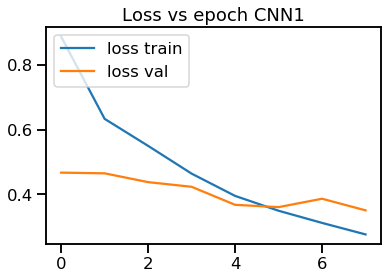

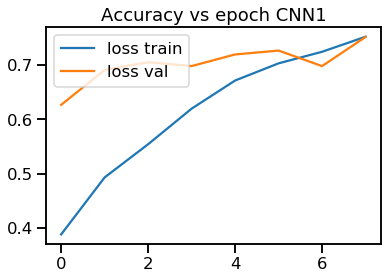


Accuracy sobre Test cnn1 : 0.7081292850146915
F1-score None sobre Test cnn1 : [0.08474576 0.23030303 0.61087866 0.82368421]
F1-score macro sobre Test cnn1 : 0.4374029161572691


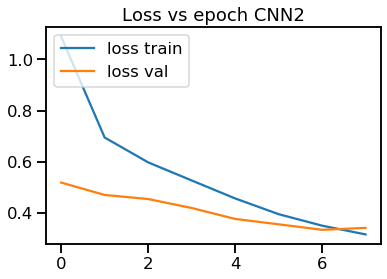

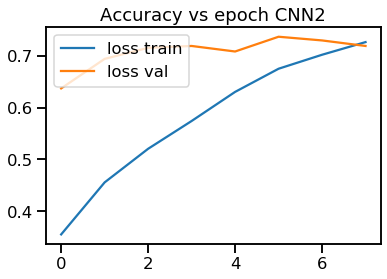


Accuracy sobre Test cnn2 : 0.7071498530852106
F1-score None sobre Test cnn2 : [0.12307692 0.23225806 0.59728507 0.8203125 ]
F1-score macro sobre Test cnn2 : 0.4432331388665888


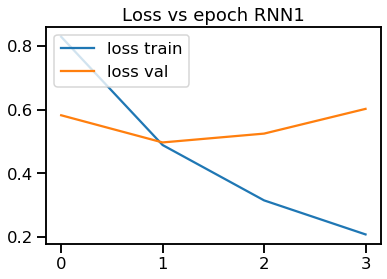

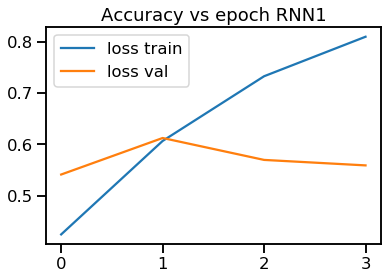


Accuracy sobre Test rnn1 : 0.5435847208619001
F1-score None sobre Test rnn1 : [0.14159292 0.24199288 0.4953271  0.68433005]
F1-score macro sobre Test rnn1 : 0.3908107396775393


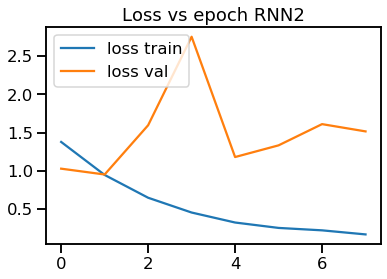

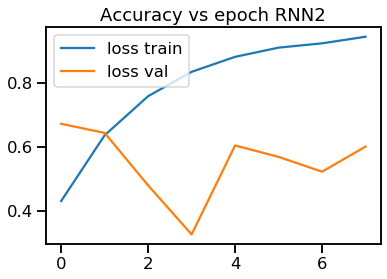


Accuracy sobre Test rnn2 : 0.6601371204701273
F1-score None sobre Test rnn2 : [0.08536585 0.2688172  0.50828729 0.78888154]
F1-score macro sobre Test rnn2 : 0.41283797154607665


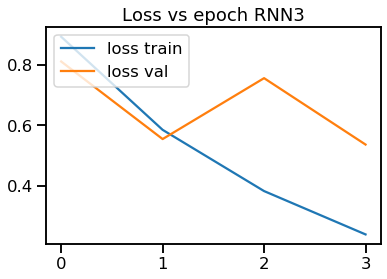

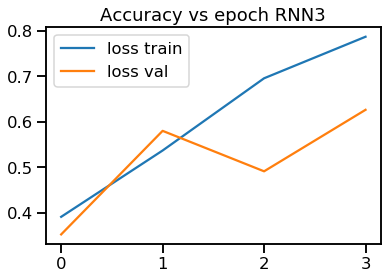


Accuracy sobre Test rnn3 : 0.5954946131243879
F1-score None sobre Test rnn3 : [0.18446602 0.23952096 0.50649351 0.72152829]
F1-score macro sobre Test rnn3 : 0.41300219300458163
----------------------- Entrenando running  2 -----------------------
Pesos de clases: [1. 1. 1. 1.]


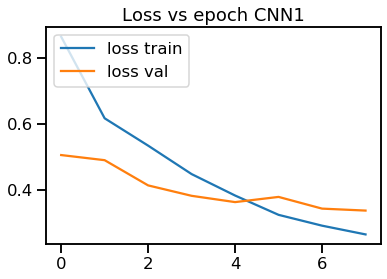

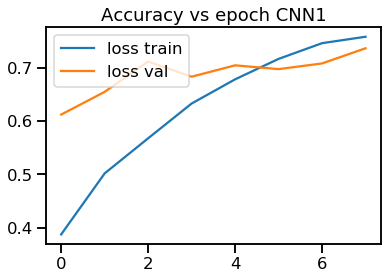


Accuracy sobre Test cnn1 : 0.7091087169441724
F1-score None sobre Test cnn1 : [0.10344828 0.26589595 0.62008734 0.81889764]
F1-score macro sobre Test cnn1 : 0.45208230091477786


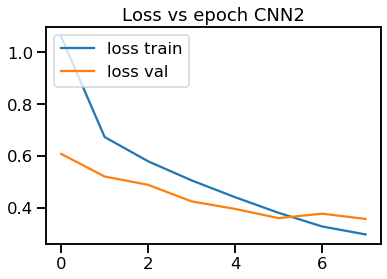

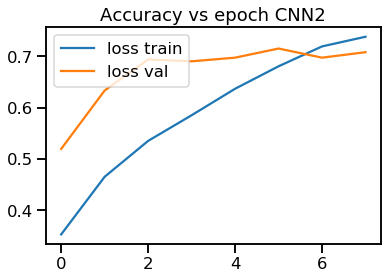


Accuracy sobre Test cnn2 : 0.7306562193927522
F1-score None sobre Test cnn2 : [0.04545455 0.22666667 0.61883408 0.83238457]
F1-score macro sobre Test cnn2 : 0.43083496489215467


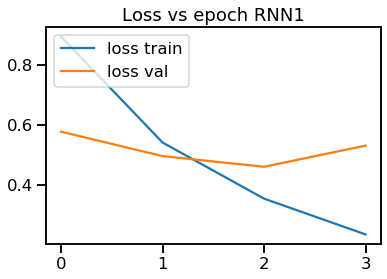

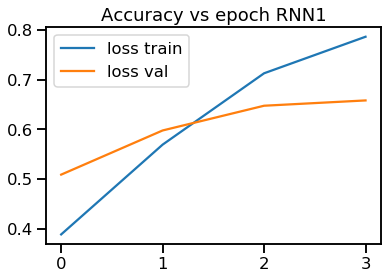


Accuracy sobre Test rnn1 : 0.6248775710088149
F1-score None sobre Test rnn1 : [0.24489796 0.24113475 0.49777778 0.74772886]
F1-score macro sobre Test rnn1 : 0.4328848374177272


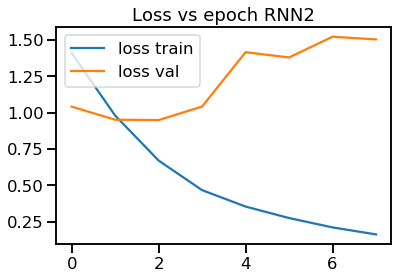

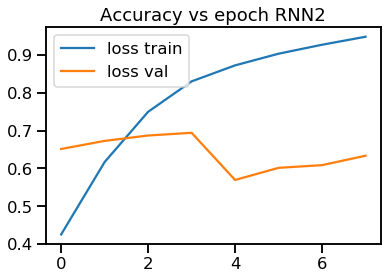


Accuracy sobre Test rnn2 : 0.6865817825661117
F1-score None sobre Test rnn2 : [0.11560694 0.10810811 0.48421053 0.81505102]
F1-score macro sobre Test rnn2 : 0.38074414781206145


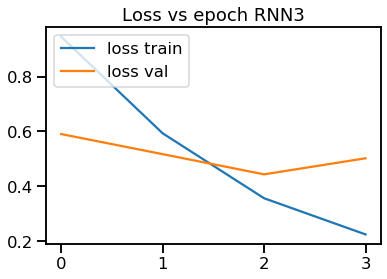

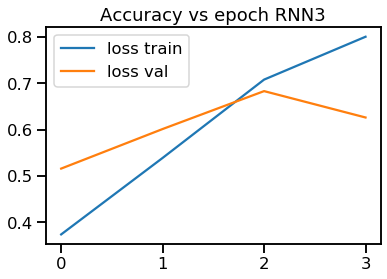


Accuracy sobre Test rnn3 : 0.6415279138099902
F1-score None sobre Test rnn3 : [0.18390805 0.25       0.49704142 0.77436946]
F1-score macro sobre Test rnn3 : 0.4263297318953451
----------------------- Entrenando running  3 -----------------------
Pesos de clases: [1. 1. 1. 1.]


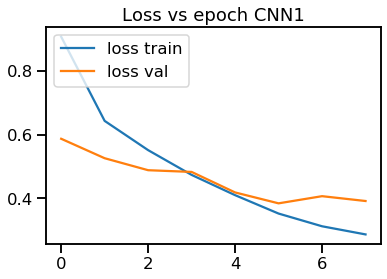

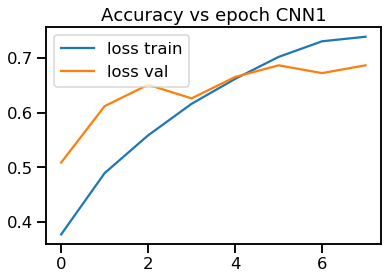


Accuracy sobre Test cnn1 : 0.6699314397649363
F1-score None sobre Test cnn1 : [0.07142857 0.23478261 0.62280702 0.79076087]
F1-score macro sobre Test cnn1 : 0.42994476680832516


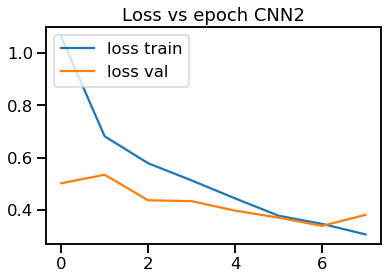

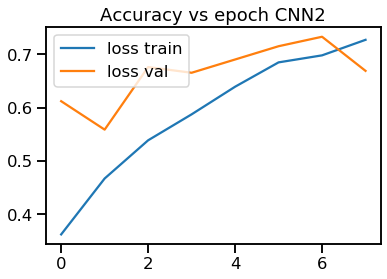


Accuracy sobre Test cnn2 : 0.6611165523996082
F1-score None sobre Test cnn2 : [0.16666667 0.24369748 0.58986175 0.78487973]
F1-score macro sobre Test cnn2 : 0.4462764054740619


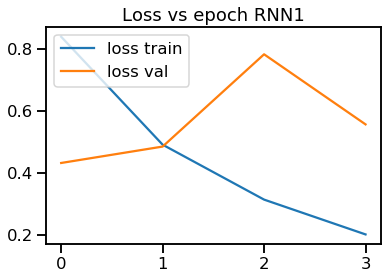

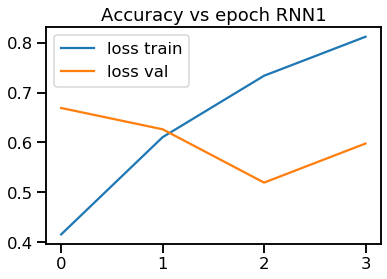


Accuracy sobre Test rnn1 : 0.5719882468168462
F1-score None sobre Test rnn1 : [0.17518248 0.23333333 0.52586207 0.70501475]
F1-score macro sobre Test rnn1 : 0.409848158328303


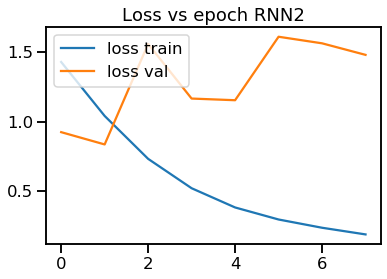

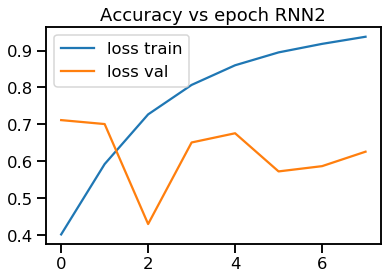


Accuracy sobre Test rnn2 : 0.5866797257590598
F1-score None sobre Test rnn2 : [0.10434783 0.25892857 0.47619048 0.72957746]
F1-score macro sobre Test rnn2 : 0.39226108462368414


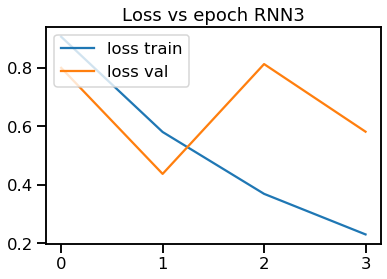

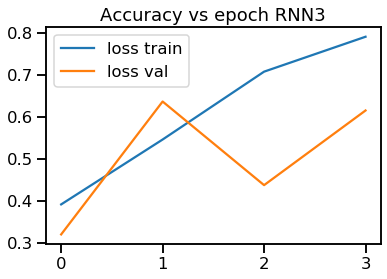


Accuracy sobre Test rnn3 : 0.6033300685602351
F1-score None sobre Test rnn3 : [0.11864407 0.25889968 0.53982301 0.73146148]
F1-score macro sobre Test rnn3 : 0.4122070590257314
----------------------- Entrenando running  4 -----------------------
Pesos de clases: [1. 1. 1. 1.]


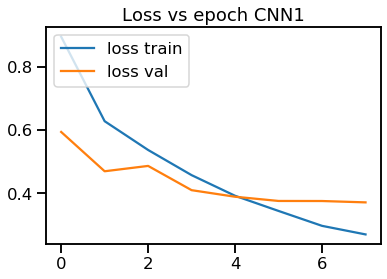

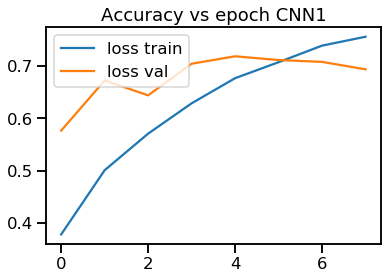


Accuracy sobre Test cnn1 : 0.7140058765915769
F1-score None sobre Test cnn1 : [0.05769231 0.25730994 0.59728507 0.82535576]
F1-score macro sobre Test cnn1 : 0.4344107684694498


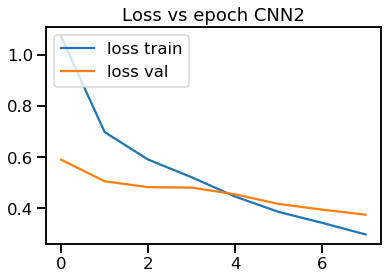

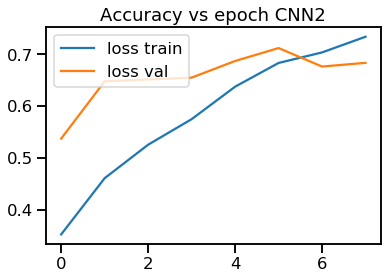


Accuracy sobre Test cnn2 : 0.6963761018609207
F1-score None sobre Test cnn2 : [0.14634146 0.25396825 0.60909091 0.80927152]
F1-score macro sobre Test cnn2 : 0.4546680374131513


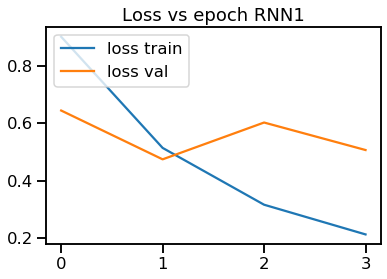

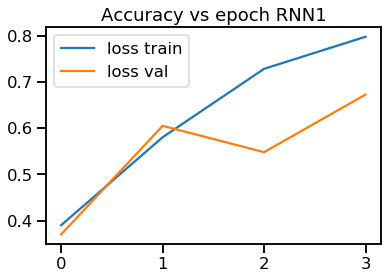


Accuracy sobre Test rnn1 : 0.6601371204701273
F1-score None sobre Test rnn1 : [0.19428571 0.20134228 0.56153846 0.78052126]
F1-score macro sobre Test rnn1 : 0.4344219299265285


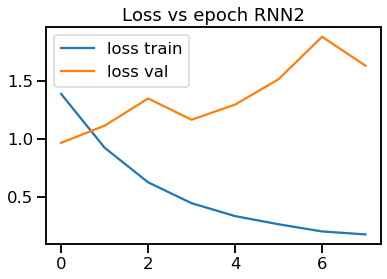

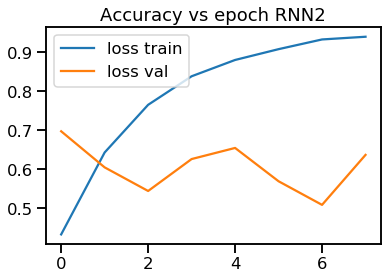


Accuracy sobre Test rnn2 : 0.7355533790401567
F1-score None sobre Test rnn2 : [0.04301075 0.23188406 0.47953216 0.84390244]
F1-score macro sobre Test rnn2 : 0.3995823533565667


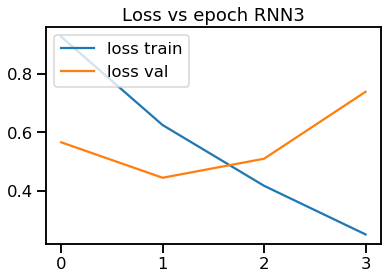

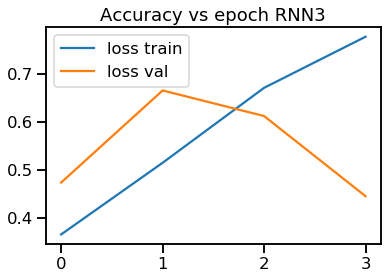


Accuracy sobre Test rnn3 : 0.42311459353574926
F1-score None sobre Test rnn3 : [0.1978022  0.23529412 0.53584906 0.52679382]
F1-score macro sobre Test rnn3 : 0.37393479896239473
----------------------- Entrenando running  5 -----------------------
Pesos de clases: [1. 1. 1. 1.]


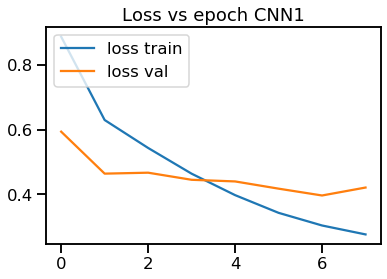

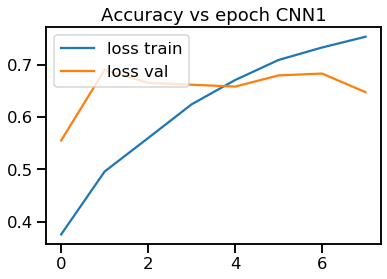


Accuracy sobre Test cnn1 : 0.6767874632713027
F1-score None sobre Test cnn1 : [0.16541353 0.24043716 0.59459459 0.79209271]
F1-score macro sobre Test cnn1 : 0.44813449827556545


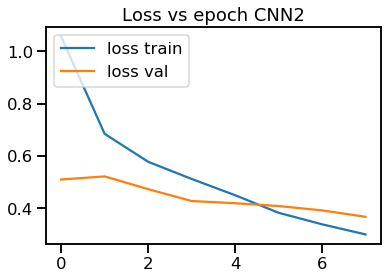

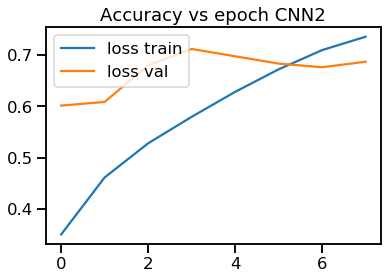


Accuracy sobre Test cnn2 : 0.7512242899118511
F1-score None sobre Test cnn2 : [0.02380952 0.21582734 0.6359447  0.85143571]
F1-score macro sobre Test cnn2 : 0.4317543169420348


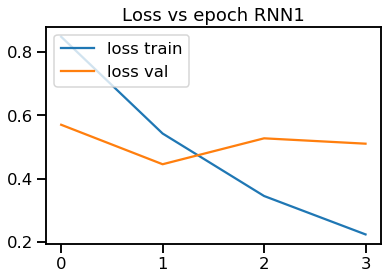

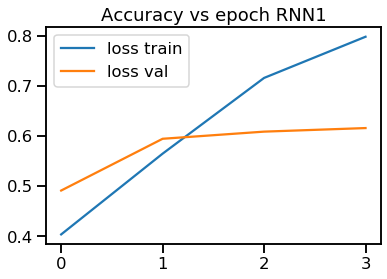


Accuracy sobre Test rnn1 : 0.5759059745347699
F1-score None sobre Test rnn1 : [0.24827586 0.16931217 0.47252747 0.71397538]
F1-score macro sobre Test rnn1 : 0.40102272101697806


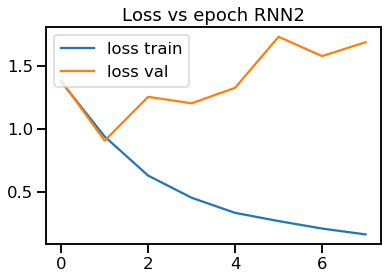

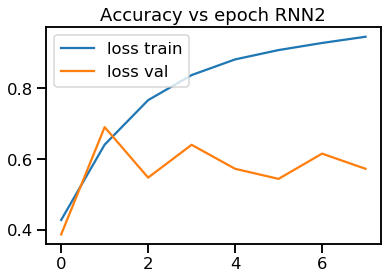


Accuracy sobre Test rnn2 : 0.604309500489716
F1-score None sobre Test rnn2 : [0.15584416 0.21004566 0.52849741 0.7505361 ]
F1-score macro sobre Test rnn2 : 0.411230831120833


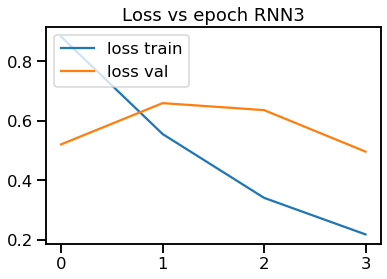

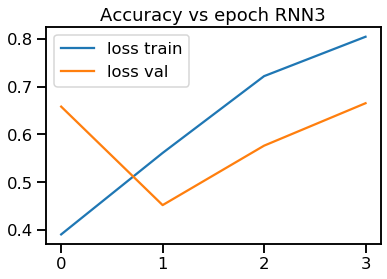


Accuracy sobre Test rnn3 : 0.6581782566111655
F1-score None sobre Test rnn3 : [0.14117647 0.21761658 0.5257732  0.79191919]
F1-score macro sobre Test rnn3 : 0.41912135967364916


In [25]:
prob=0.15 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()

    trained.save('../new_glove_augmented/stance_baselines/0.15/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    trained.save('../new_glove_augmented/stance_baselines/0.15/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_4e.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_4e.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [26]:
#menos epochs
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.09654569 0.24574574 0.60913054 0.81015824]
(0.15) app1 F1-score promedio para cnn2 : [0.10106982 0.23448356 0.6102033  0.8196568 ]
(0.15) app1 F1-score promedio para rnn1 : [0.20084699 0.21742308 0.51060658 0.72631406]
(0.15) app1 F1-score promedio para rnn2 : [0.1008351  0.21555672 0.49534357 0.78558971]
(0.15) app1 F1-score promedio para rnn3 : [0.16519936 0.24026627 0.52099604 0.70921445]

(0.15) app1 F1-score macro promedio para cnn1 : 0.4403950501250775 desvest:  0.00837214193275568
(0.15) app1 F1-score macro promedio para cnn2 : 0.4413533727175983 desvest:  0.009031376896308143
(0.15) app1 F1-score macro promedio para rnn1 : 0.4137976772734152 desvest:  0.017302467957851782
(0.15) app1 F1-score macro promedio para rnn2 : 0.3993312776918444 desvest:  0.011996351252440939
(0.15) app1 F1-score macro promedio para rnn3 : 0.4089190285123404 desvest:  0.01821318120234335

(0.15) app1 Accuracy promedio para cnn1 : 0.695592556317336
(0.15) app

### 0.15

----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]


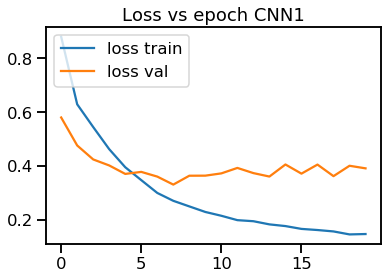

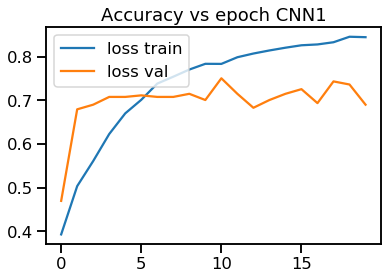


Accuracy sobre Test cnn1 : 0.6944172380019589
F1-score None sobre Test cnn1 : [0.12162162 0.10084034 0.49142857 0.81375   ]
F1-score macro sobre Test cnn1 : 0.38191013229616166


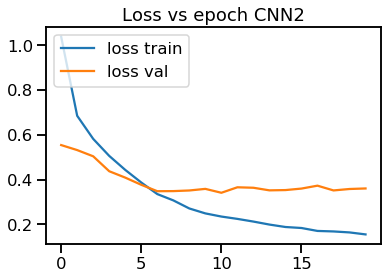

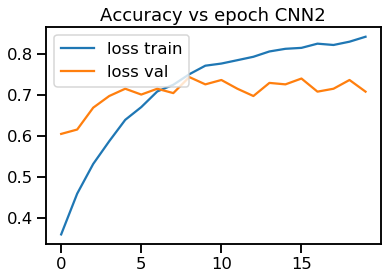


Accuracy sobre Test cnn2 : 0.693437806072478
F1-score None sobre Test cnn2 : [0.10144928 0.17910448 0.52525253 0.81043257]
F1-score macro sobre Test cnn2 : 0.40405971205033475


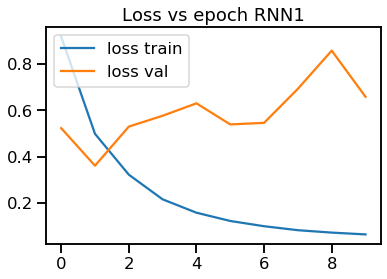

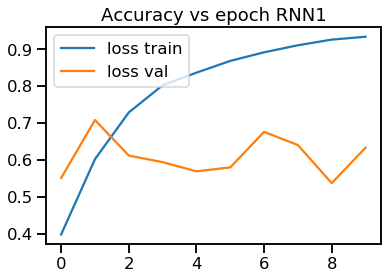


Accuracy sobre Test rnn1 : 0.6581782566111655
F1-score None sobre Test rnn1 : [0.12       0.14545455 0.40236686 0.79078695]
F1-score macro sobre Test rnn1 : 0.36465208938411364


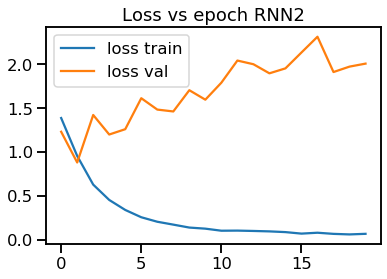

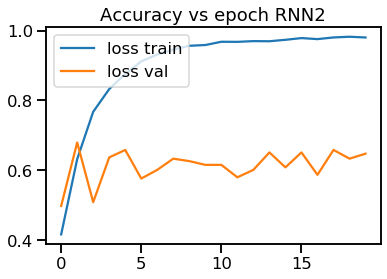


Accuracy sobre Test rnn2 : 0.6718903036238981
F1-score None sobre Test rnn2 : [0.08130081 0.23655914 0.43930636 0.79615385]
F1-score macro sobre Test rnn2 : 0.3883300393321063


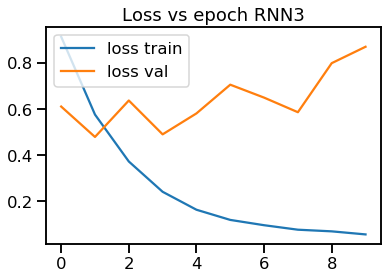

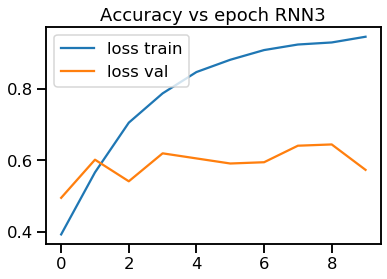


Accuracy sobre Test rnn3 : 0.6346718903036239
F1-score None sobre Test rnn3 : [0.11688312 0.27777778 0.47398844 0.7696514 ]
F1-score macro sobre Test rnn3 : 0.40957518379940044
----------------------- Entrenando running  2 -----------------------
Pesos de clases: [1. 1. 1. 1.]


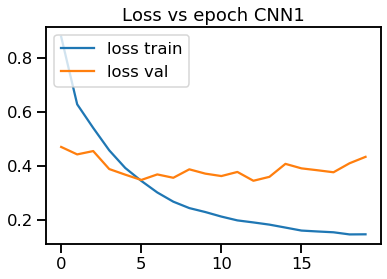

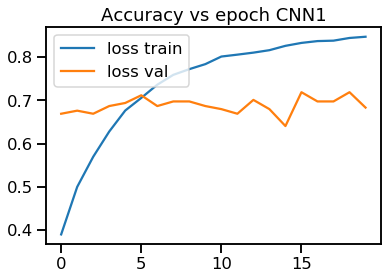


Accuracy sobre Test cnn1 : 0.6963761018609207
F1-score None sobre Test cnn1 : [0.16551724 0.23376623 0.53535354 0.81294498]
F1-score macro sobre Test cnn1 : 0.4368954985794624


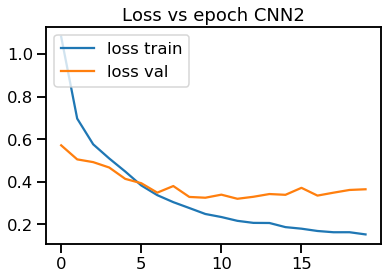

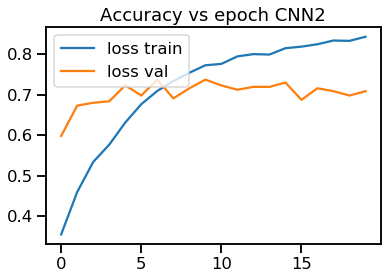


Accuracy sobre Test cnn2 : 0.6856023506366308
F1-score None sobre Test cnn2 : [0.112      0.24338624 0.59555556 0.80239521]
F1-score macro sobre Test cnn2 : 0.4383342521306593


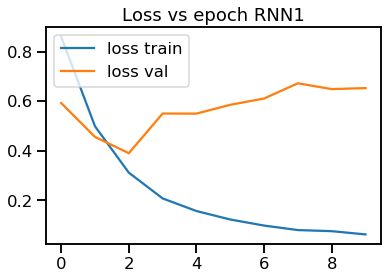

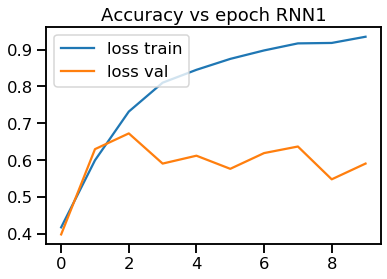


Accuracy sobre Test rnn1 : 0.6023506366307542
F1-score None sobre Test rnn1 : [0.10483871 0.16216216 0.45814978 0.74313187]
F1-score macro sobre Test rnn1 : 0.3670706299267832


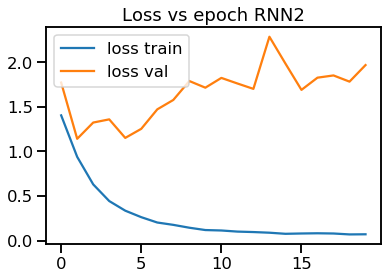

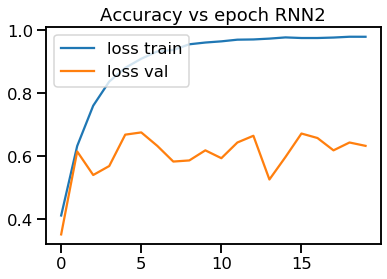


Accuracy sobre Test rnn2 : 0.6787463271302644
F1-score None sobre Test rnn2 : [0.14       0.16176471 0.59887006 0.80444735]
F1-score macro sobre Test rnn2 : 0.42627052839736734


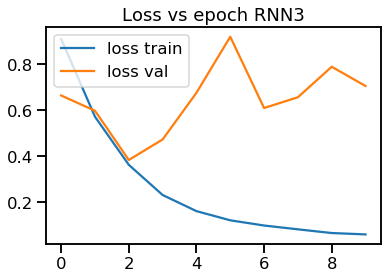

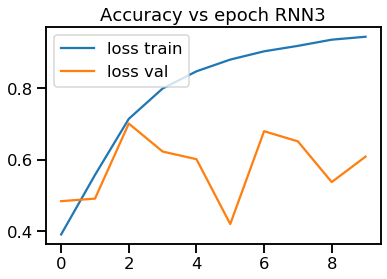


Accuracy sobre Test rnn3 : 0.6483839373163565
F1-score None sobre Test rnn3 : [0.17431193 0.24778761 0.50202429 0.77459016]
F1-score macro sobre Test rnn3 : 0.4246784981643439
----------------------- Entrenando running  3 -----------------------
Pesos de clases: [1. 1. 1. 1.]


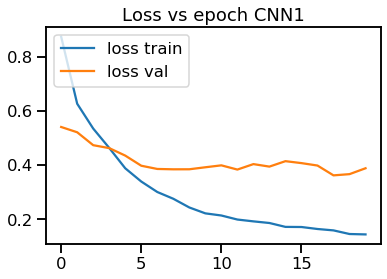

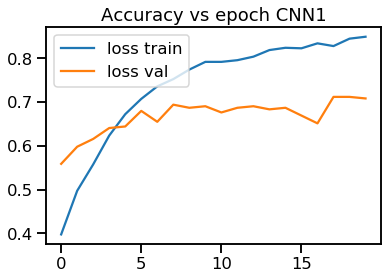


Accuracy sobre Test cnn1 : 0.6591576885406464
F1-score None sobre Test cnn1 : [0.19161677 0.25136612 0.5026178  0.78081279]
F1-score macro sobre Test cnn1 : 0.43160336980127934


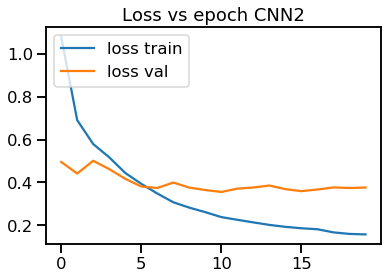

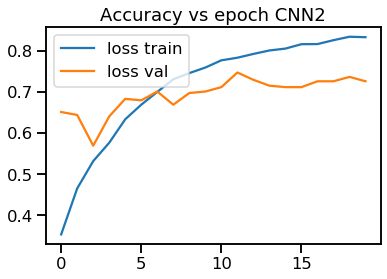


Accuracy sobre Test cnn2 : 0.7208619000979432
F1-score None sobre Test cnn2 : [0.10619469 0.17322835 0.4972973  0.83240569]
F1-score macro sobre Test cnn2 : 0.40228150589200584


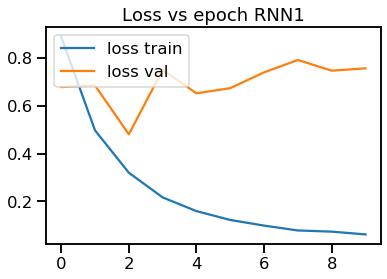

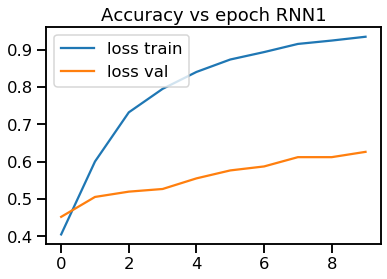


Accuracy sobre Test rnn1 : 0.643486777668952
F1-score None sobre Test rnn1 : [0.19157088 0.08695652 0.50731707 0.77628032]
F1-score macro sobre Test rnn1 : 0.39053119989651264


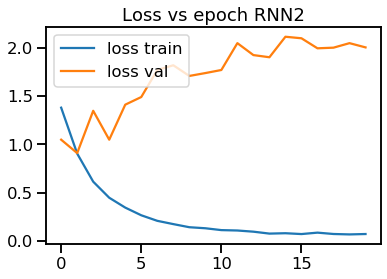

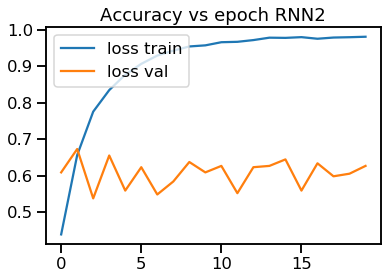


Accuracy sobre Test rnn2 : 0.7100881488736532
F1-score None sobre Test rnn2 : [0.08264463 0.09302326 0.44144144 0.82703038]
F1-score macro sobre Test rnn2 : 0.3610349258829695


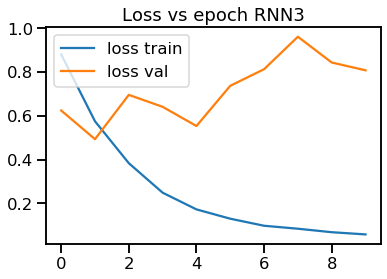

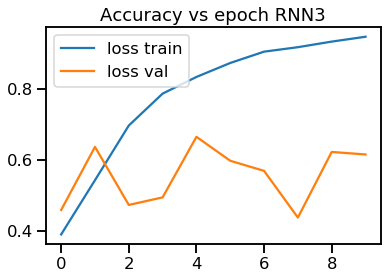


Accuracy sobre Test rnn3 : 0.6523016650342801
F1-score None sobre Test rnn3 : [0.12359551 0.26530612 0.44025157 0.78727634]
F1-score macro sobre Test rnn3 : 0.40410738558557785
----------------------- Entrenando running  4 -----------------------
Pesos de clases: [1. 1. 1. 1.]


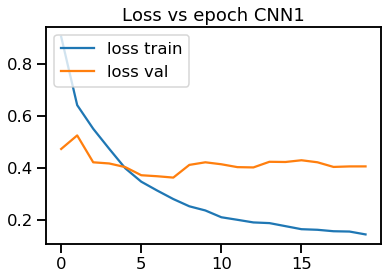

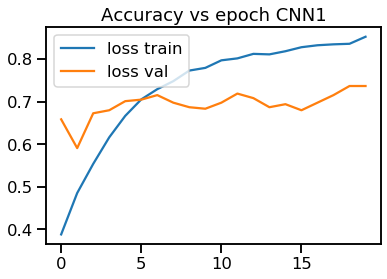


Accuracy sobre Test cnn1 : 0.7218413320274241
F1-score None sobre Test cnn1 : [0.08130081 0.18897638 0.58252427 0.83228247]
F1-score macro sobre Test cnn1 : 0.42127098360807


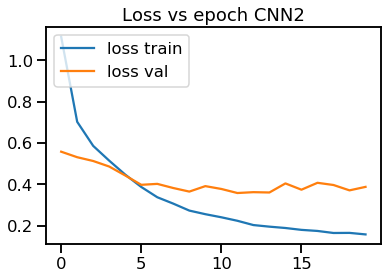

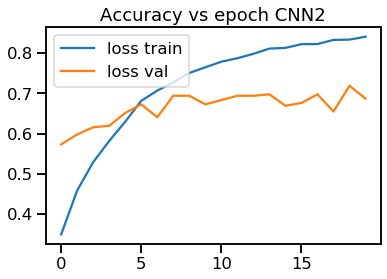


Accuracy sobre Test cnn2 : 0.6895200783545543
F1-score None sobre Test cnn2 : [0.08053691 0.29069767 0.59487179 0.80602883]
F1-score macro sobre Test cnn2 : 0.4430338038984617


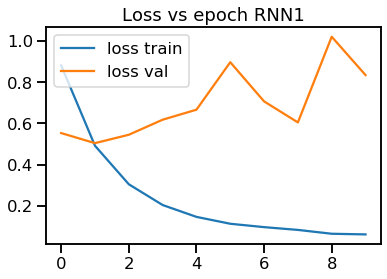

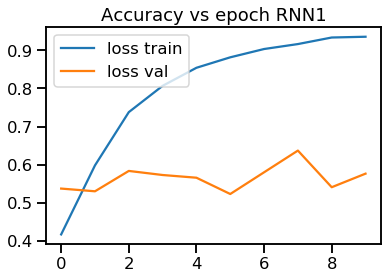


Accuracy sobre Test rnn1 : 0.5817825661116552
F1-score None sobre Test rnn1 : [0.14049587 0.24       0.47619048 0.72123894]
F1-score macro sobre Test rnn1 : 0.39448132050304213


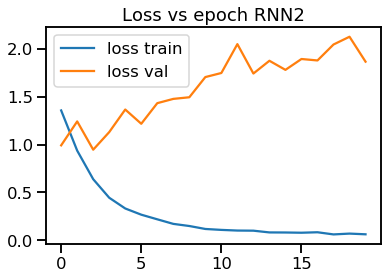

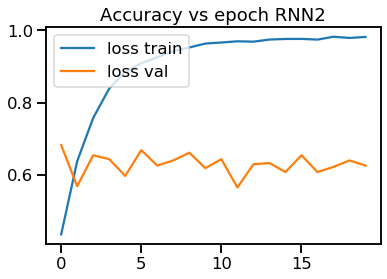


Accuracy sobre Test rnn2 : 0.67384916748286
F1-score None sobre Test rnn2 : [0.11320755 0.20588235 0.39534884 0.80126984]
F1-score macro sobre Test rnn2 : 0.37892714464753285


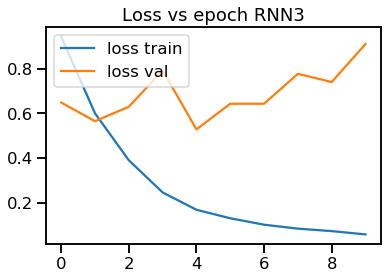

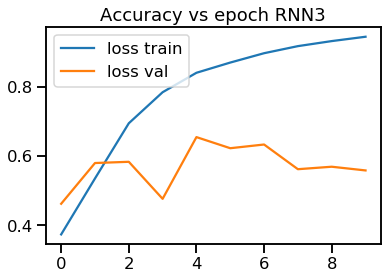


Accuracy sobre Test rnn3 : 0.5465230166503428
F1-score None sobre Test rnn3 : [0.15841584 0.20689655 0.47120419 0.69591078]
F1-score macro sobre Test rnn3 : 0.3831068406147792
----------------------- Entrenando running  5 -----------------------
Pesos de clases: [1. 1. 1. 1.]


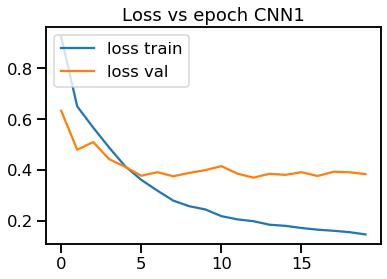

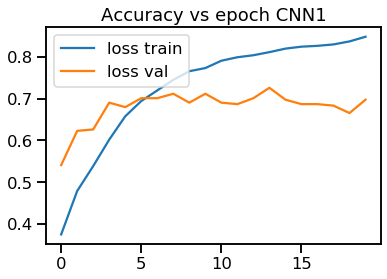


Accuracy sobre Test cnn1 : 0.7218413320274241
F1-score None sobre Test cnn1 : [0.07751938 0.21848739 0.57142857 0.82978723]
F1-score macro sobre Test cnn1 : 0.4243056450685173


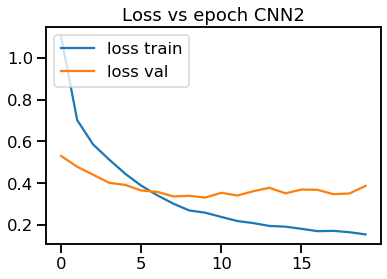

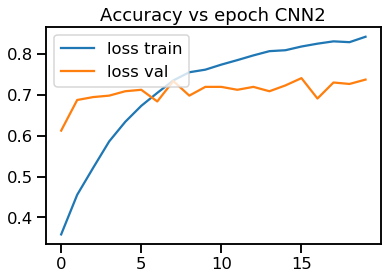


Accuracy sobre Test cnn2 : 0.7316356513222331
F1-score None sobre Test cnn2 : [0.11538462 0.20740741 0.49411765 0.83894672]
F1-score macro sobre Test cnn2 : 0.41396409841800863


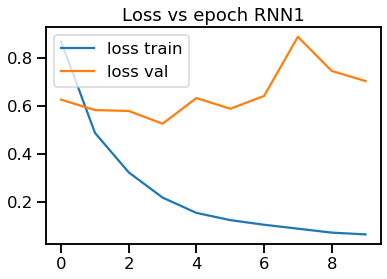

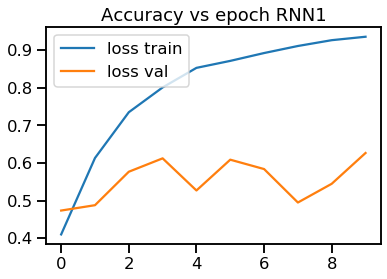


Accuracy sobre Test rnn1 : 0.6640548481880509
F1-score None sobre Test rnn1 : [0.13265306 0.18032787 0.52534562 0.79230259]
F1-score macro sobre Test rnn1 : 0.4076572850299476


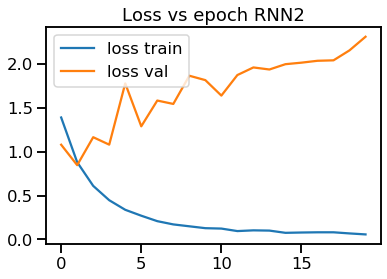

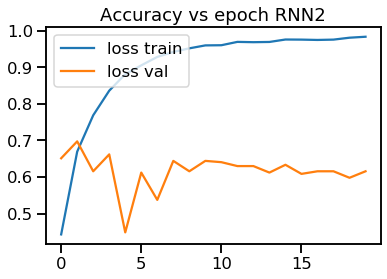


Accuracy sobre Test rnn2 : 0.6464250734573947
F1-score None sobre Test rnn2 : [0.05952381 0.16793893 0.4375     0.78341014]
F1-score macro sobre Test rnn2 : 0.36209321976759185


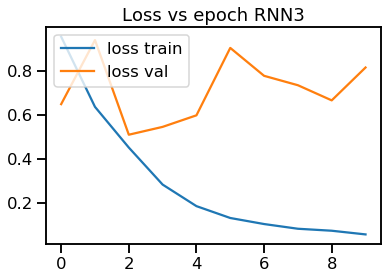

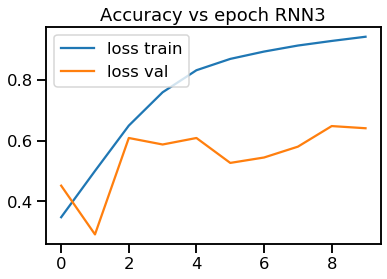


Accuracy sobre Test rnn3 : 0.6875612144955926
F1-score None sobre Test rnn3 : [0.10989011 0.19642857 0.35616438 0.81772784]
F1-score macro sobre Test rnn3 : 0.37005272627001884


In [28]:
prob=0.15 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()

    trained.save('../new_glove_augmented/stance_baselines/0.15/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    trained.save('../new_glove_augmented/stance_baselines/0.15/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [ ]:
#menos epochs
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

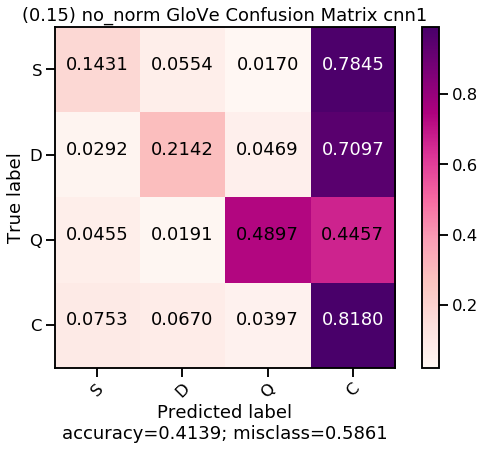

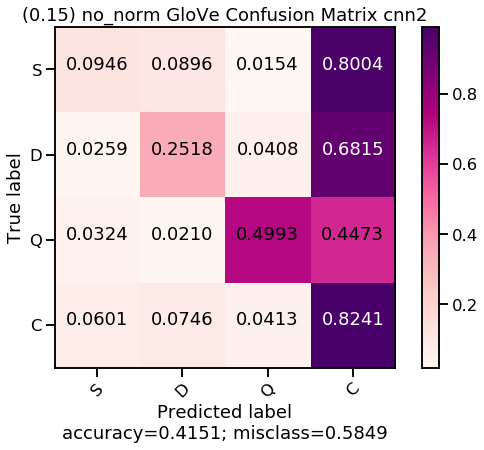

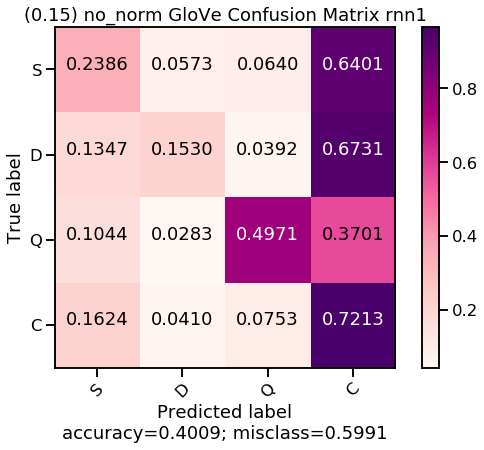

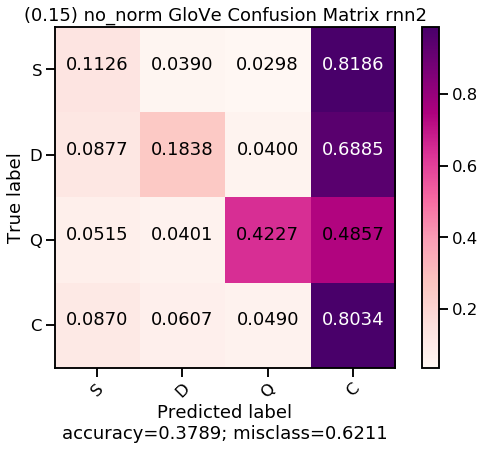

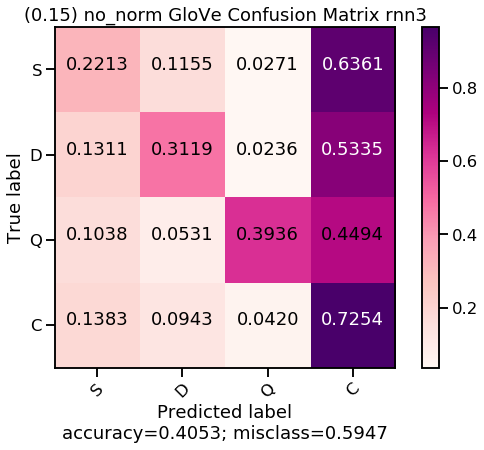

In [30]:
###correr de nuevo, no la saqué para 0.15 (esta es de otra config)
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) no_norm GloVe Confusion Matrix "+str(key), cmap='RdPu')

### 0.5

----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


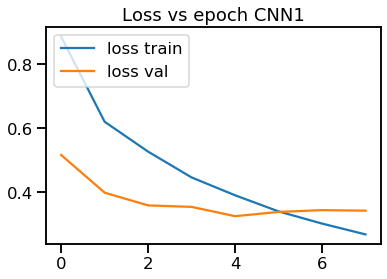

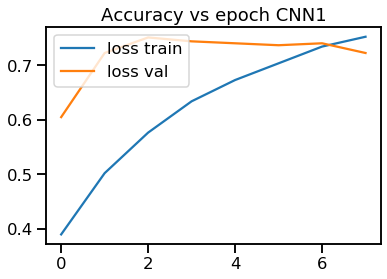


Accuracy sobre Test cnn1 : 0.7306562193927522
F1-score None sobre Test cnn1 : [0.08333333 0.25675676 0.55555556 0.835     ]
F1-score macro sobre Test cnn1 : 0.43266141141141146


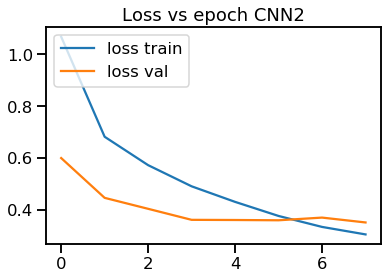

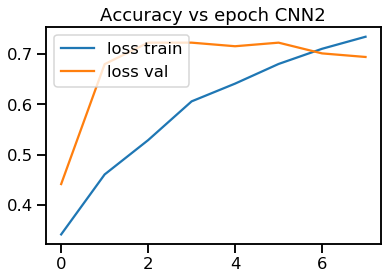


Accuracy sobre Test cnn2 : 0.672869735553379
F1-score None sobre Test cnn2 : [0.11267606 0.21978022 0.60683761 0.79245283]
F1-score macro sobre Test cnn2 : 0.4329366782861335


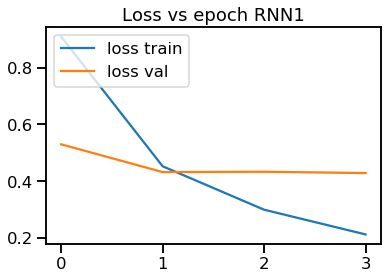

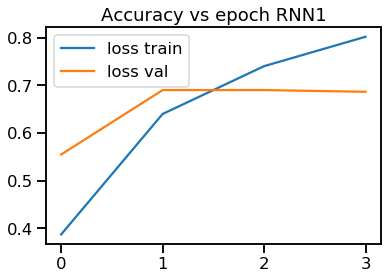


Accuracy sobre Test rnn1 : 0.6875612144955926
F1-score None sobre Test rnn1 : [0.15172414 0.07792208 0.48993289 0.80814717]
F1-score macro sobre Test rnn1 : 0.381931569132298


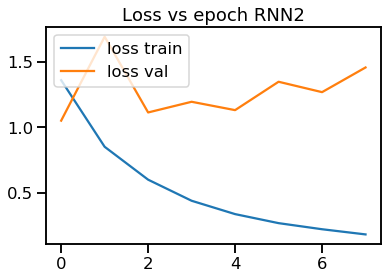

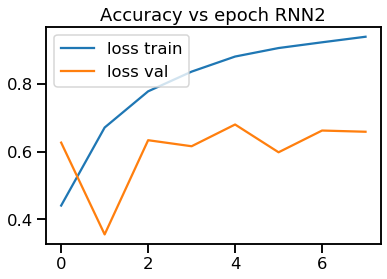


Accuracy sobre Test rnn2 : 0.7257590597453477
F1-score None sobre Test rnn2 : [0.03389831 0.1372549  0.38961039 0.84172662]
F1-score macro sobre Test rnn2 : 0.3506225538402389


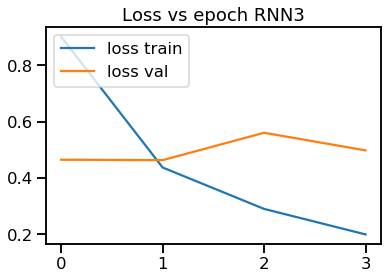

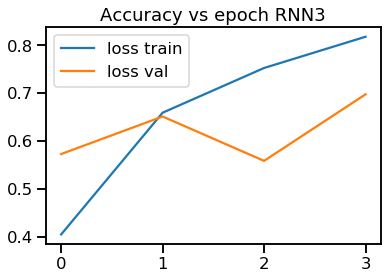


Accuracy sobre Test rnn3 : 0.7100881488736532
F1-score None sobre Test rnn3 : [0.1322314  0.23899371 0.44578313 0.8283208 ]
F1-score macro sobre Test rnn3 : 0.41133226254640864
----------------------- Entrenando running  2 -----------------------
Pesos de clases: [1. 1. 1. 1.]


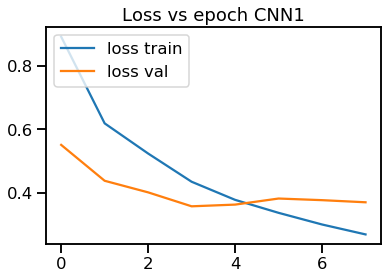

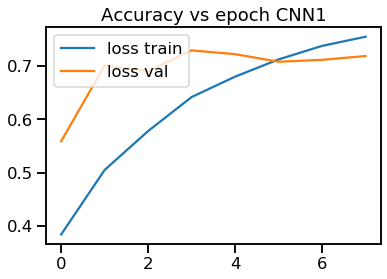


Accuracy sobre Test cnn1 : 0.6944172380019589
F1-score None sobre Test cnn1 : [0.12903226 0.18934911 0.56872038 0.81274382]
F1-score macro sobre Test cnn1 : 0.4249613931961037


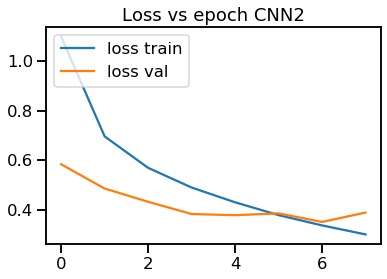

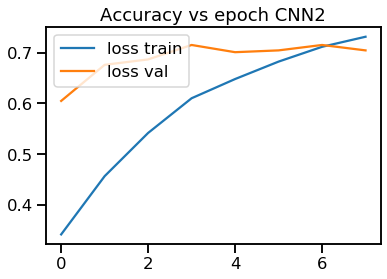


Accuracy sobre Test cnn2 : 0.67384916748286
F1-score None sobre Test cnn2 : [0.1300813  0.21111111 0.54098361 0.79598662]
F1-score macro sobre Test cnn2 : 0.4195406601387688


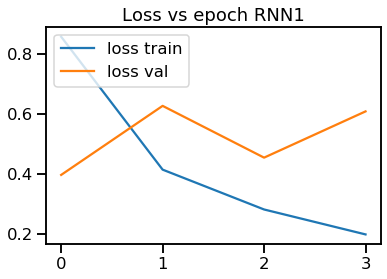

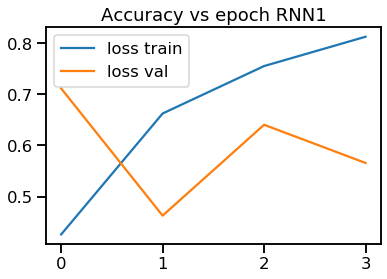


Accuracy sobre Test rnn1 : 0.5142017629774731
F1-score None sobre Test rnn1 : [0.19814241 0.16107383 0.49019608 0.64240506]
F1-score macro sobre Test rnn1 : 0.3729543455216372


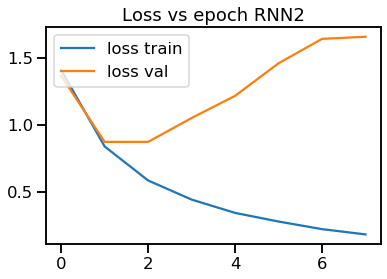

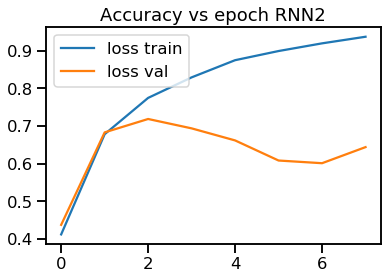


Accuracy sobre Test rnn2 : 0.6807051909892262
F1-score None sobre Test rnn2 : [0.13333333 0.21359223 0.5        0.80569948]
F1-score macro sobre Test rnn2 : 0.4131562620520818


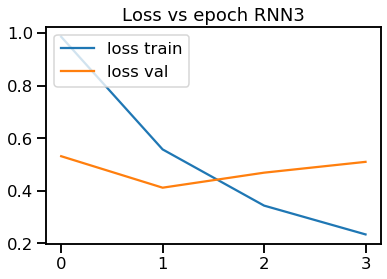

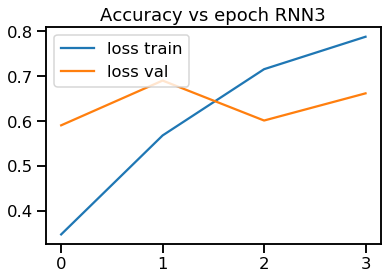


Accuracy sobre Test rnn3 : 0.6689520078354554
F1-score None sobre Test rnn3 : [0.12658228 0.21118012 0.51960784 0.79394338]
F1-score macro sobre Test rnn3 : 0.4128284074117513
----------------------- Entrenando running  3 -----------------------
Pesos de clases: [1. 1. 1. 1.]


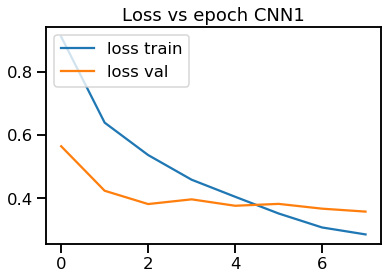

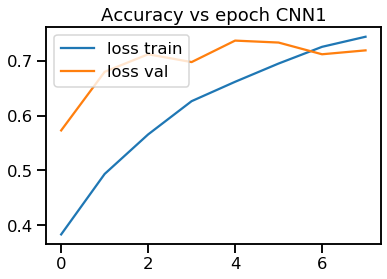


Accuracy sobre Test cnn1 : 0.7100881488736532
F1-score None sobre Test cnn1 : [0.09677419 0.18897638 0.47513812 0.82484472]
F1-score macro sobre Test cnn1 : 0.3964333533862497


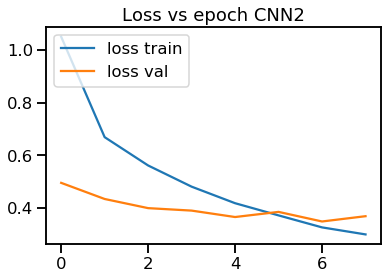

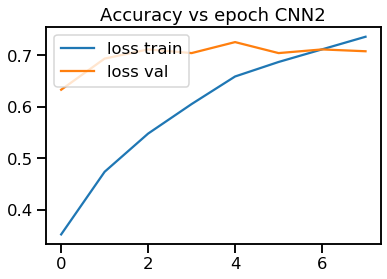


Accuracy sobre Test cnn2 : 0.7208619000979432
F1-score None sobre Test cnn2 : [0.04347826 0.2208589  0.58986175 0.83057325]
F1-score macro sobre Test cnn2 : 0.4211930390337009


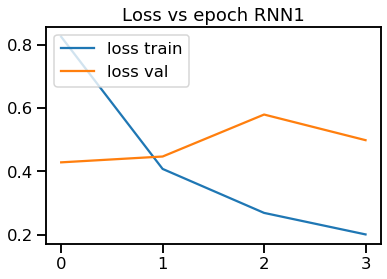

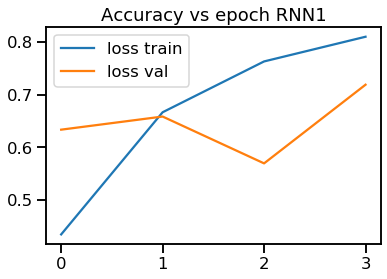


Accuracy sobre Test rnn1 : 0.6748285994123409
F1-score None sobre Test rnn1 : [0.15602837 0.23232323 0.59555556 0.79566982]
F1-score macro sobre Test rnn1 : 0.44489424518992937


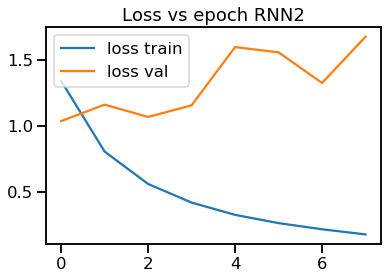

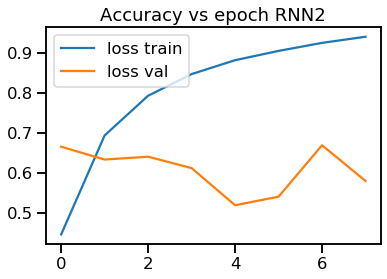


Accuracy sobre Test rnn2 : 0.6052889324191969
F1-score None sobre Test rnn2 : [0.14511041 0.19607843 0.41772152 0.75358362]
F1-score macro sobre Test rnn2 : 0.3781234945504921


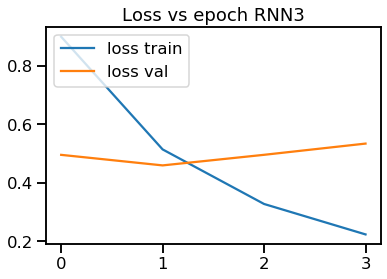

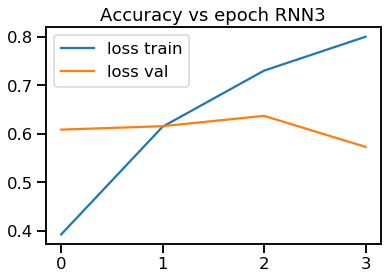


Accuracy sobre Test rnn3 : 0.5680705190989226
F1-score None sobre Test rnn3 : [0.22222222 0.23622047 0.46280992 0.70029674]
F1-score macro sobre Test rnn3 : 0.40538733698089585
----------------------- Entrenando running  4 -----------------------
Pesos de clases: [1. 1. 1. 1.]


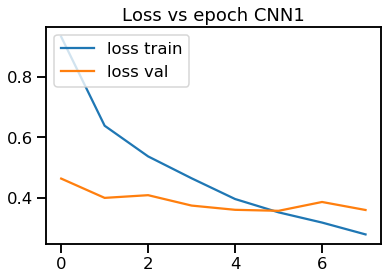

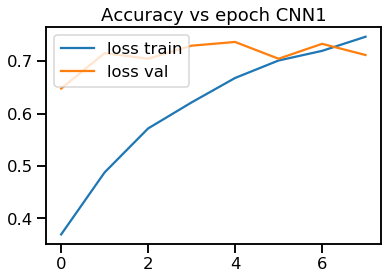


Accuracy sobre Test cnn1 : 0.7296767874632712
F1-score None sobre Test cnn1 : [0.1322314  0.21538462 0.57843137 0.83679899]
F1-score macro sobre Test cnn1 : 0.44071159617518907


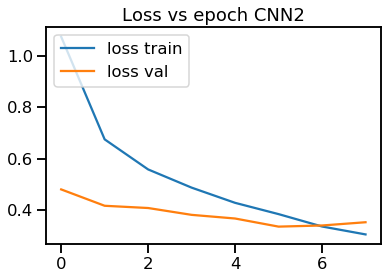

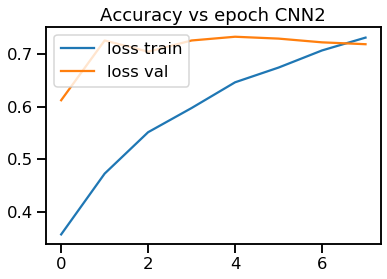


Accuracy sobre Test cnn2 : 0.722820763956905
F1-score None sobre Test cnn2 : [0.15       0.24489796 0.60185185 0.82873637]
F1-score macro sobre Test cnn2 : 0.4563715451257832


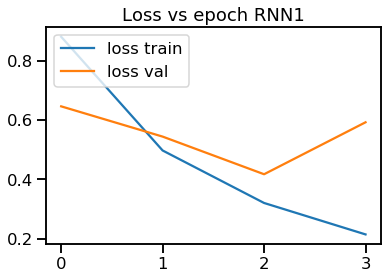

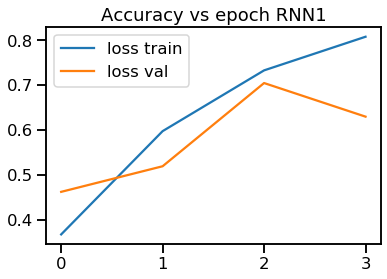


Accuracy sobre Test rnn1 : 0.544564152791381
F1-score None sobre Test rnn1 : [0.15172414 0.2122905  0.38095238 0.69777778]
F1-score macro sobre Test rnn1 : 0.3606861998636223


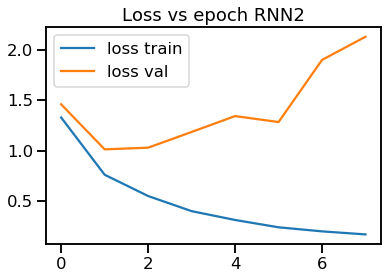

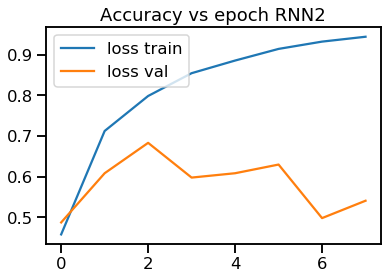


Accuracy sobre Test rnn2 : 0.6190009794319294
F1-score None sobre Test rnn2 : [0.08264463 0.20437956 0.55555556 0.75331936]
F1-score macro sobre Test rnn2 : 0.39897477569786666


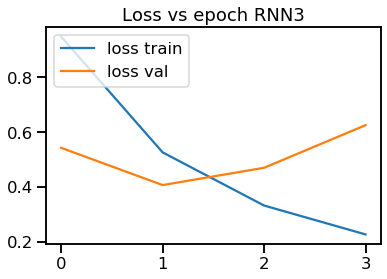

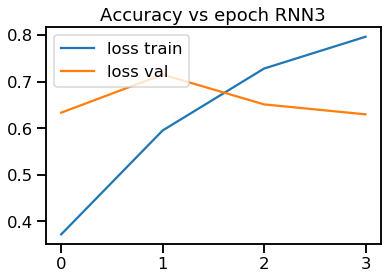


Accuracy sobre Test rnn3 : 0.614103819784525
F1-score None sobre Test rnn3 : [0.14349776 0.21538462 0.15254237 0.77158035]
F1-score macro sobre Test rnn3 : 0.32075127284975735
----------------------- Entrenando running  5 -----------------------
Pesos de clases: [1. 1. 1. 1.]


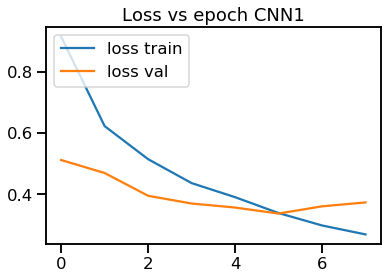

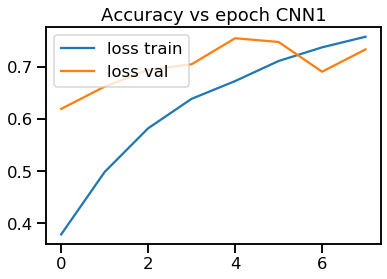


Accuracy sobre Test cnn1 : 0.702252693437806
F1-score None sobre Test cnn1 : [0.1322314  0.21935484 0.53703704 0.81806452]
F1-score macro sobre Test cnn1 : 0.42667194920860607


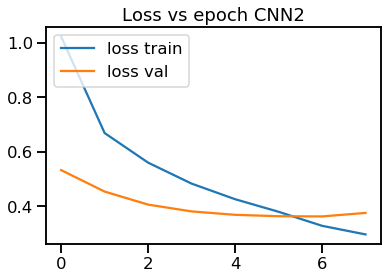

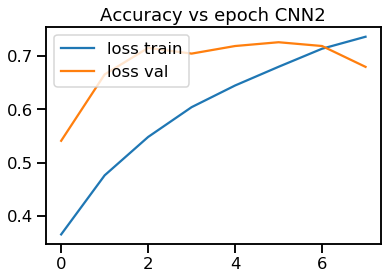


Accuracy sobre Test cnn2 : 0.6993143976493633
F1-score None sobre Test cnn2 : [0.09803922 0.16949153 0.56       0.81637876]
F1-score macro sobre Test cnn2 : 0.4109773749767971


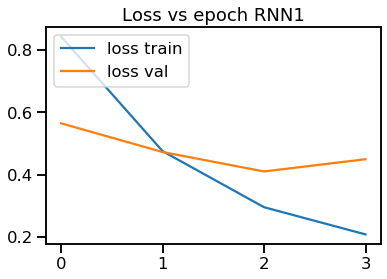

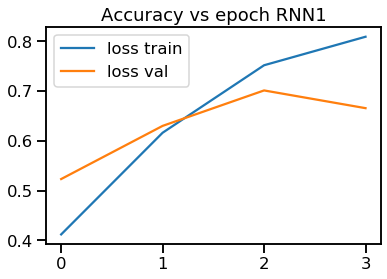


Accuracy sobre Test rnn1 : 0.683643486777669
F1-score None sobre Test rnn1 : [0.15652174 0.26470588 0.32911392 0.81277955]
F1-score macro sobre Test rnn1 : 0.39078027456241593


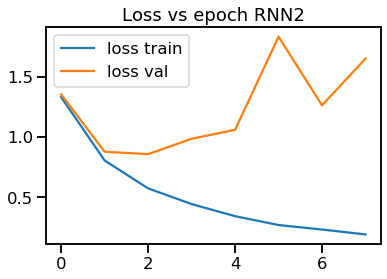

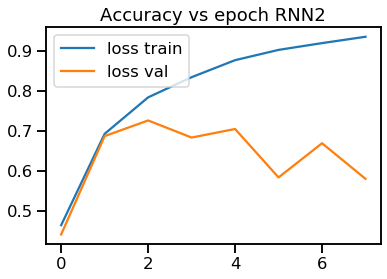


Accuracy sobre Test rnn2 : 0.5269343780607247
F1-score None sobre Test rnn2 : [0.16891892 0.22881356 0.51555556 0.66614786]
F1-score macro sobre Test rnn2 : 0.3948589734296718


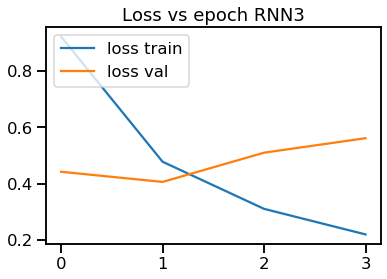

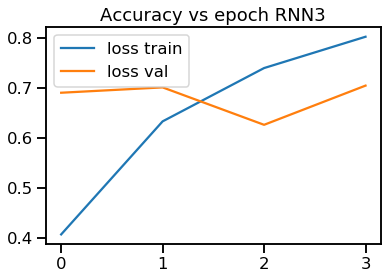


Accuracy sobre Test rnn3 : 0.7110675808031341
F1-score None sobre Test rnn3 : [0.07575758 0.11881188 0.08547009 0.8392435 ]
F1-score macro sobre Test rnn3 : 0.2798207603084367


In [19]:
prob=0.5 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_4e.h5')
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.5/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_4e.h5')
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [20]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) 8-4e app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) 8-4e app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) 8-4e app1 Accuracy promedio para",key,":" ,temp/5)

(0.5) 8-4e app1 F1-score promedio para cnn1 : [0.11472052 0.21396434 0.54297649 0.82549041]
(0.5) 8-4e app1 F1-score promedio para cnn2 : [0.10685497 0.21322794 0.57990696 0.81282557]
(0.5) 8-4e app1 F1-score promedio para rnn1 : [0.16282816 0.1896631  0.45715016 0.75135588]
(0.5) 8-4e app1 F1-score promedio para rnn2 : [0.11278112 0.19602374 0.4756886  0.76409539]
(0.5) 8-4e app1 F1-score promedio para rnn3 : [0.14005825 0.20411816 0.33324267 0.78667695]

(0.5) 8-4e app1 F1-score macro promedio para cnn1 : 0.42428794067551195 desvest:  0.014979095701513678
(0.5) 8-4e app1 F1-score macro promedio para cnn2 : 0.4282038595122367 desvest:  0.015727507640987473
(0.5) 8-4e app1 F1-score macro promedio para rnn1 : 0.3902493268539805 desvest:  0.029081365014945123
(0.5) 8-4e app1 F1-score macro promedio para rnn2 : 0.38714721191407026 desvest:  0.021407061182156323
(0.5) 8-4e app1 F1-score macro promedio para rnn3 : 0.36602400801945 desvest:  0.055269488623203605

(0.5) 8-4e app1 Accuracy pro

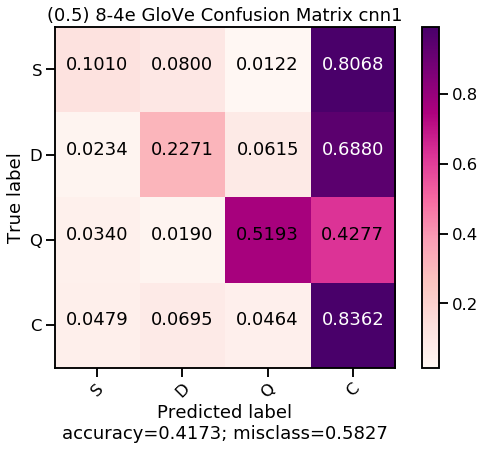

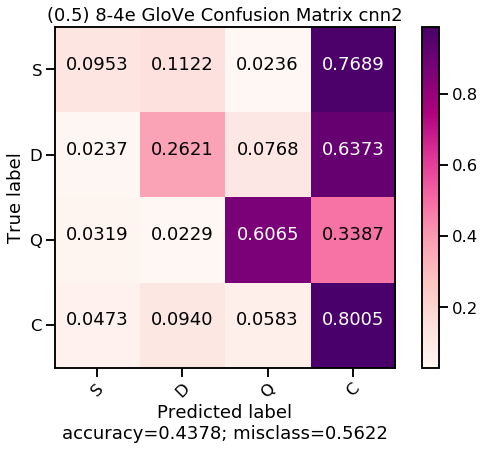

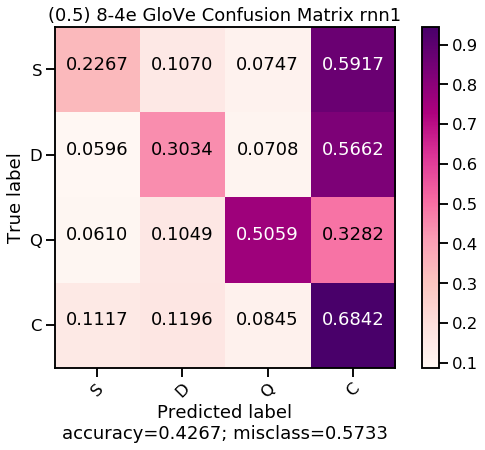

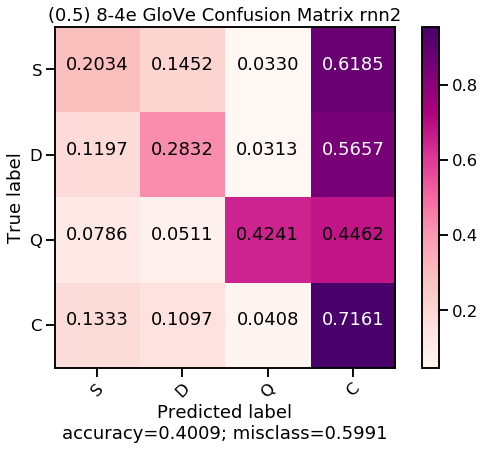

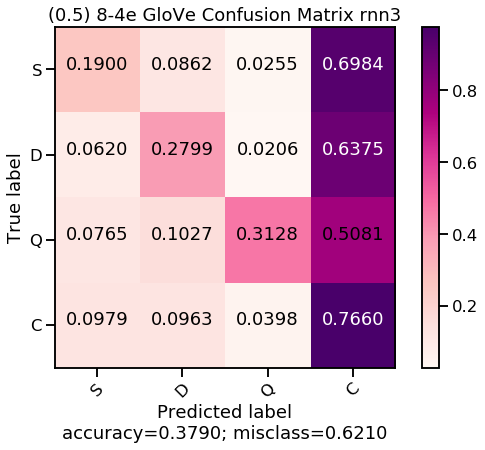

In [21]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.5) 8-4e GloVe Confusion Matrix "+str(key), cmap='RdPu')

### 0.85

----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]


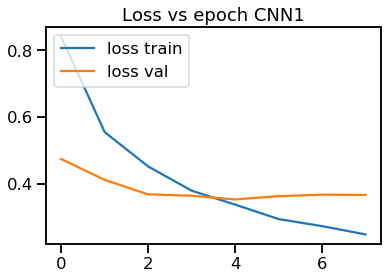

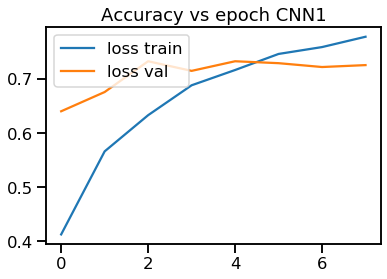


Accuracy sobre Test cnn1 : 0.7345739471106758
F1-score None sobre Test cnn1 : [0.11111111 0.1981982  0.51207729 0.84158416]
F1-score macro sobre Test cnn1 : 0.41574269060278535


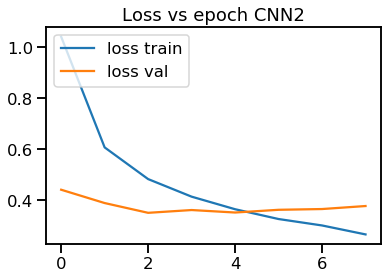

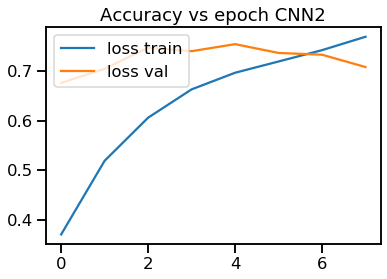


Accuracy sobre Test cnn2 : 0.713026444662096
F1-score None sobre Test cnn2 : [0.07017544 0.16528926 0.5        0.82884013]
F1-score macro sobre Test cnn2 : 0.39107620504667195


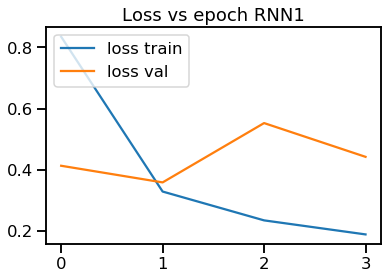

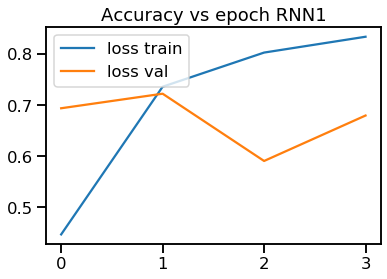


Accuracy sobre Test rnn1 : 0.713026444662096
F1-score None sobre Test rnn1 : [0.         0.11510791 0.37037037 0.83032491]
F1-score macro sobre Test rnn1 : 0.32895079844668185


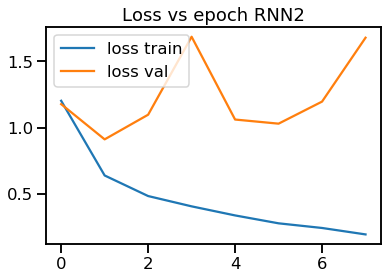

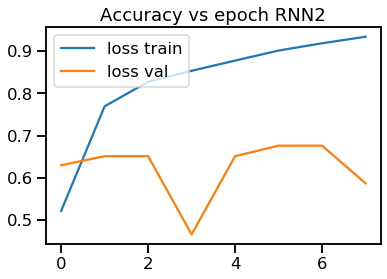


Accuracy sobre Test rnn2 : 0.7051909892262488
F1-score None sobre Test rnn2 : [0.02531646 0.1954023  0.203125   0.82962071]
F1-score macro sobre Test rnn2 : 0.31336611624054744


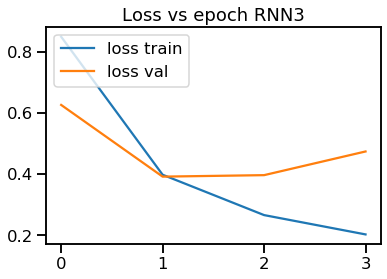

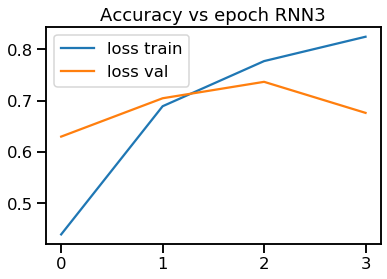


Accuracy sobre Test rnn3 : 0.6611165523996082
F1-score None sobre Test rnn3 : [0.04301075 0.21428571 0.55905512 0.78585996]
F1-score macro sobre Test rnn3 : 0.40055288607388584
----------------------- Entrenando running  2 -----------------------
Pesos de clases: [1. 1. 1. 1.]


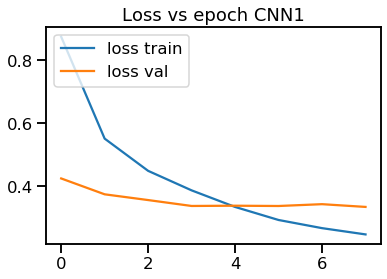

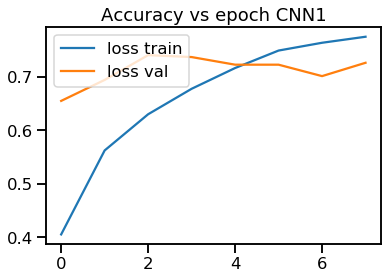


Accuracy sobre Test cnn1 : 0.7394711067580804
F1-score None sobre Test cnn1 : [0.06060606 0.21818182 0.4047619  0.84804805]
F1-score macro sobre Test cnn1 : 0.3828994578994579


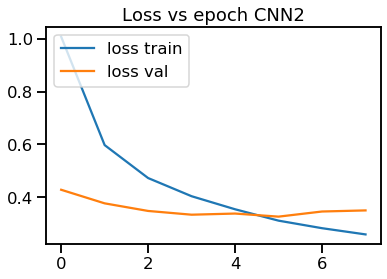

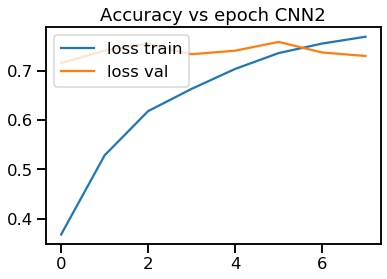


Accuracy sobre Test cnn2 : 0.752203721841332
F1-score None sobre Test cnn2 : [0.04597701 0.20183486 0.52083333 0.85247884]
F1-score macro sobre Test cnn2 : 0.40528101159766455


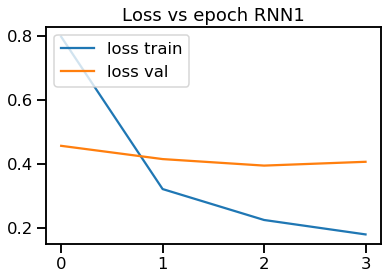

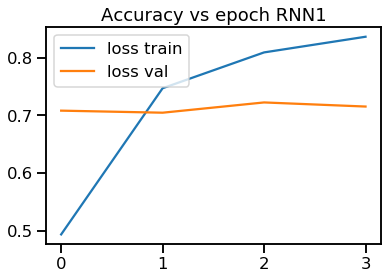


Accuracy sobre Test rnn1 : 0.732615083251714
F1-score None sobre Test rnn1 : [0.10619469 0.15686275 0.49756098 0.84217016]
F1-score macro sobre Test rnn1 : 0.40069714281730323


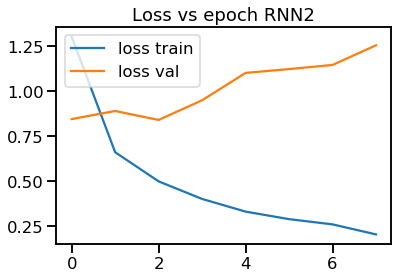

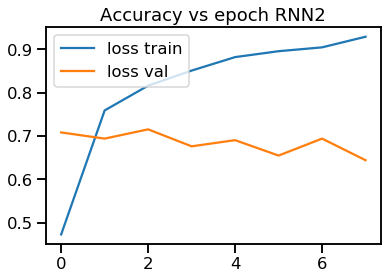


Accuracy sobre Test rnn2 : 0.6777668952007836
F1-score None sobre Test rnn2 : [0.09271523 0.25142857 0.4        0.80842912]
F1-score macro sobre Test rnn2 : 0.3881432304976493


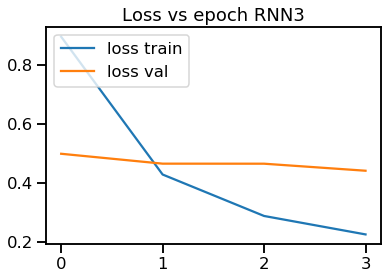

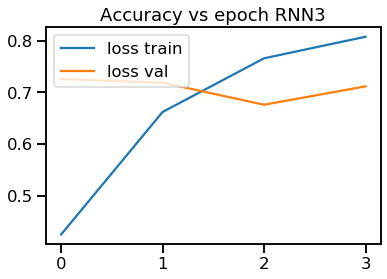


Accuracy sobre Test rnn3 : 0.7443682664054848
F1-score None sobre Test rnn3 : [0.06666667 0.08695652 0.34782609 0.8534432 ]
F1-score macro sobre Test rnn3 : 0.33872311931144494
----------------------- Entrenando running  3 -----------------------
Pesos de clases: [1. 1. 1. 1.]


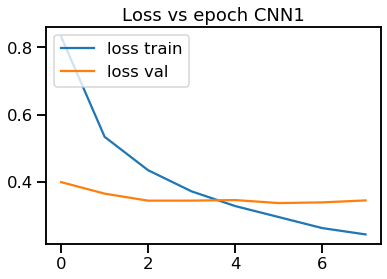

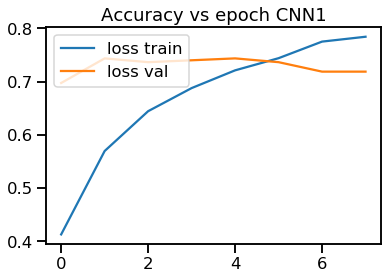


Accuracy sobre Test cnn1 : 0.7453476983349657
F1-score None sobre Test cnn1 : [0.04545455 0.24793388 0.53080569 0.84833539]
F1-score macro sobre Test cnn1 : 0.4181323763413072


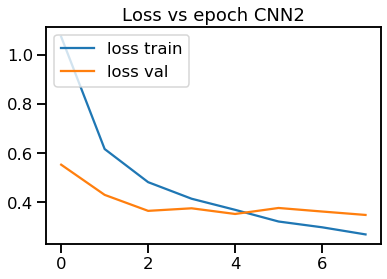

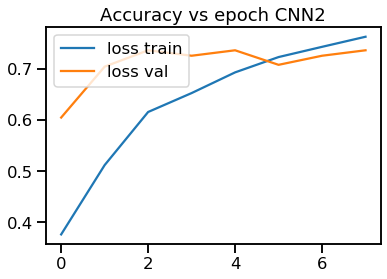


Accuracy sobre Test cnn2 : 0.742409402546523
F1-score None sobre Test cnn2 : [0.         0.16806723 0.54205607 0.84975369]
F1-score macro sobre Test cnn2 : 0.38996924905959807


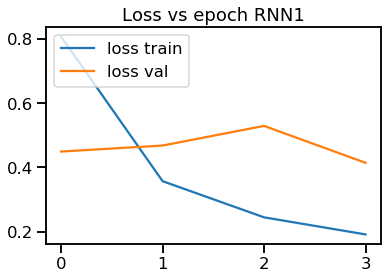

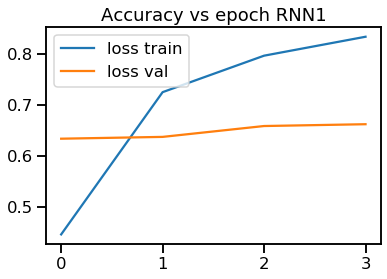


Accuracy sobre Test rnn1 : 0.7394711067580804
F1-score None sobre Test rnn1 : [0.06185567 0.18032787 0.51336898 0.84718826]
F1-score macro sobre Test rnn1 : 0.4006851967428627


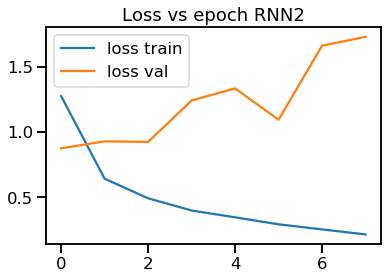

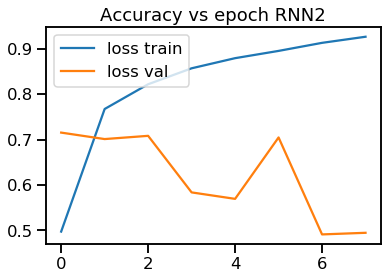


Accuracy sobre Test rnn2 : 0.5073457394711067
F1-score None sobre Test rnn2 : [0.13186813 0.25179856 0.4137931  0.64133017]
F1-score macro sobre Test rnn2 : 0.3596974906845677


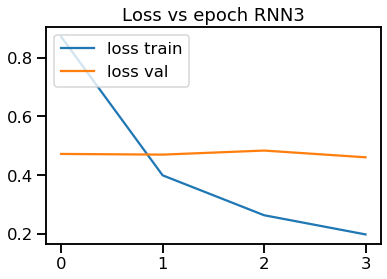

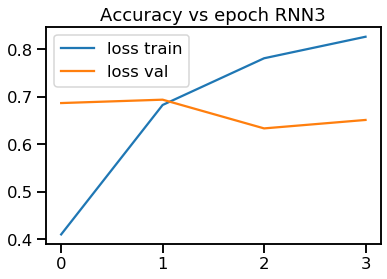


Accuracy sobre Test rnn3 : 0.7247796278158668
F1-score None sobre Test rnn3 : [0.02409639 0.27096774 0.34210526 0.8377724 ]
F1-score macro sobre Test rnn3 : 0.36873544693249455
----------------------- Entrenando running  4 -----------------------
Pesos de clases: [1. 1. 1. 1.]


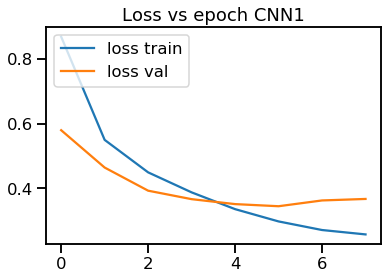

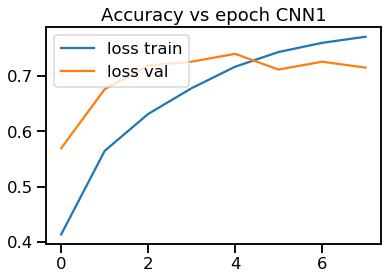


Accuracy sobre Test cnn1 : 0.7394711067580804
F1-score None sobre Test cnn1 : [0.12612613 0.20689655 0.46060606 0.84606061]
F1-score macro sobre Test cnn1 : 0.4099223361292327


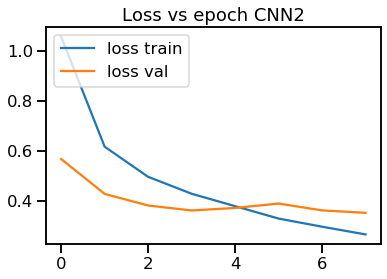

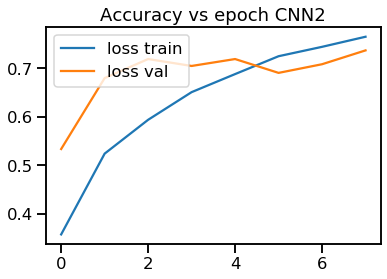


Accuracy sobre Test cnn2 : 0.7414299706170421
F1-score None sobre Test cnn2 : [0.09259259 0.19642857 0.51813472 0.84837324]
F1-score macro sobre Test cnn2 : 0.41388227854015935


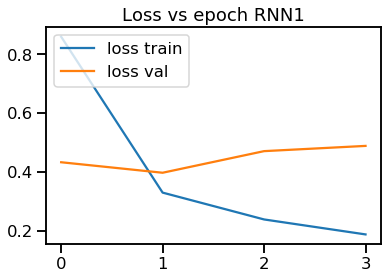

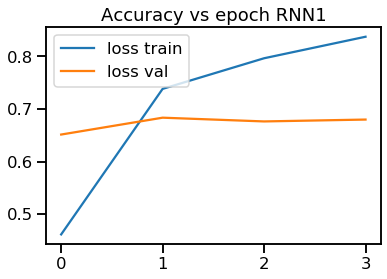


Accuracy sobre Test rnn1 : 0.67384916748286
F1-score None sobre Test rnn1 : [0.15492958 0.19161677 0.52678571 0.79787939]
F1-score macro sobre Test rnn1 : 0.41780286213557183


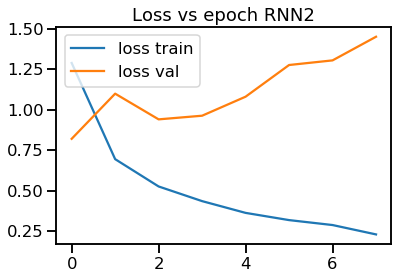

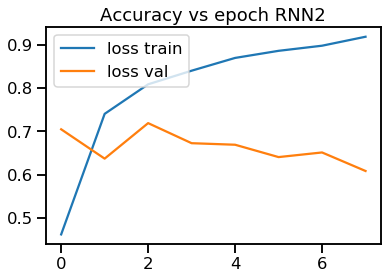


Accuracy sobre Test rnn2 : 0.614103819784525
F1-score None sobre Test rnn2 : [0.16091954 0.21428571 0.5        0.75      ]
F1-score macro sobre Test rnn2 : 0.4063013136288999


In [ ]:
prob=0.85 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
      
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_4e.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.85/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_8e.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'_4e.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='loss train')
    plt.plot(hist.history['val_acc'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [27]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.85) 8-4e app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.85) 8-4e app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.85) 8-4e app1 Accuracy promedio para",key,":" ,temp/5)

(0.85) 8-4e app1 F1-score promedio para cnn1 : [0.09130108 0.22461246 0.47365019 0.84370133]
(0.85) 8-4e app1 F1-score promedio para cnn2 : [0.05807554 0.18545442 0.52820482 0.8485284 ]
(0.85) 8-4e app1 F1-score promedio para rnn1 : [0.08937475 0.18011996 0.48677185 0.82733683]
(0.85) 8-4e app1 F1-score promedio para rnn2 : [0.08704192 0.22637865 0.36264288 0.77507031]
(0.85) 8-4e app1 F1-score promedio para rnn3 : [0.07568198 0.14407614 0.39594688 0.82995636]

(0.85) 8-4e app1 F1-score macro promedio para cnn1 : 0.4083162646940471 desvest:  0.012986474541787713
(0.85) 8-4e app1 F1-score macro promedio para cnn2 : 0.40506579649293173 desvest:  0.013443003529550773
(0.85) 8-4e app1 F1-score macro promedio para rnn1 : 0.39590084703813677 desvest:  0.035400105478051155
(0.85) 8-4e app1 F1-score macro promedio para rnn2 : 0.3627834405288108 desvest:  0.03242418808763857
(0.85) 8-4e app1 F1-score macro promedio para rnn3 : 0.36141533994736685 desvest:  0.02337711606015101

(0.85) 8-4e app1 

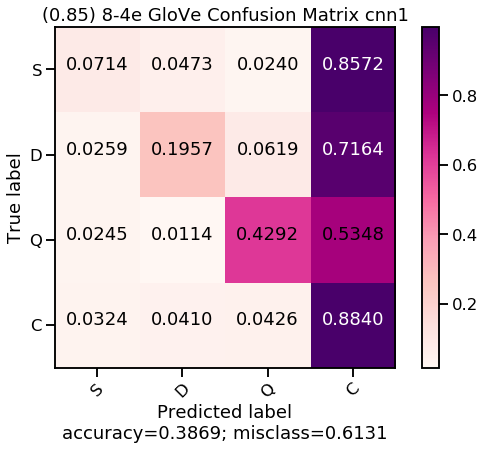

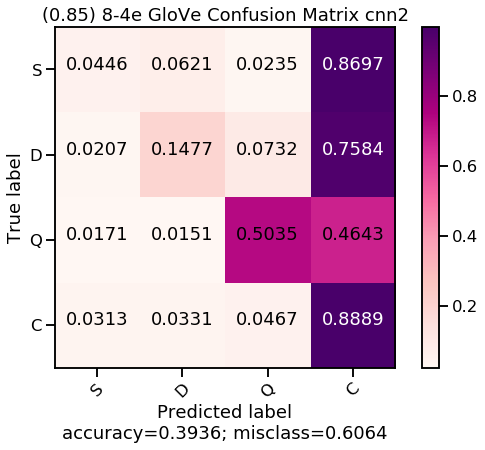

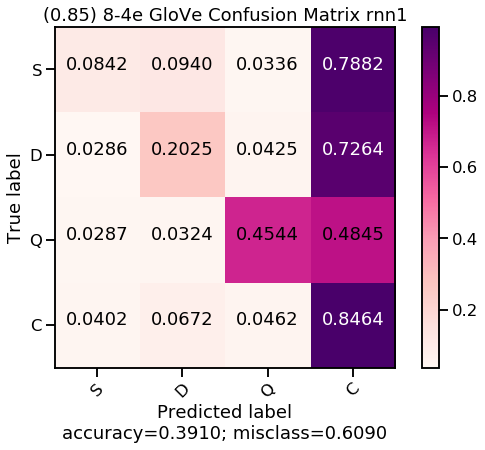

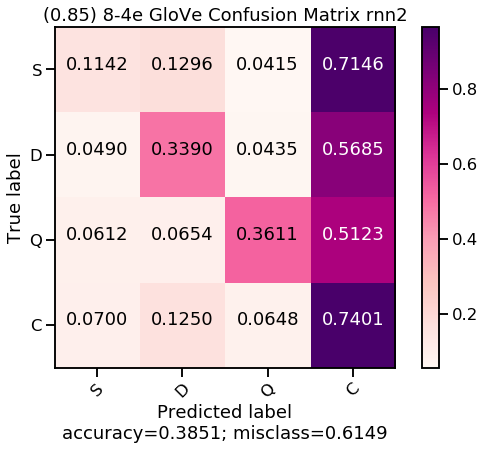

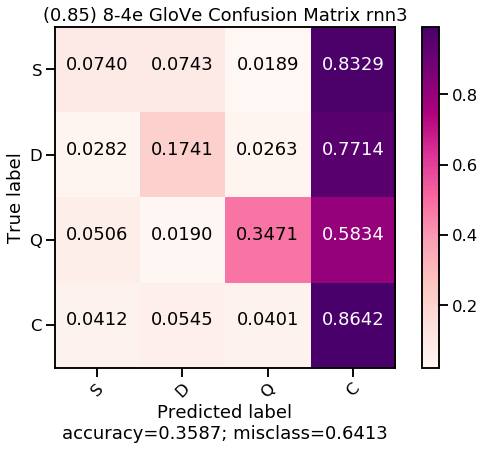

In [28]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.85) 8-4e GloVe Confusion Matrix "+str(key), cmap='RdPu')

In [37]:
"listo 3" 

'listo 3'

In [26]:
fs_none

{'cnn1': [array([0.11111111, 0.1981982 , 0.51207729, 0.84158416]),
  array([0.06060606, 0.21818182, 0.4047619 , 0.84804805]),
  array([0.04545455, 0.24793388, 0.53080569, 0.84833539]),
  array([0.12612613, 0.20689655, 0.46060606, 0.84606061]),
  array([0.11320755, 0.25185185, 0.46      , 0.83447845])],
 'cnn2': [array([0.07017544, 0.16528926, 0.5       , 0.82884013]),
  array([0.04597701, 0.20183486, 0.52083333, 0.85247884]),
  array([0.        , 0.16806723, 0.54205607, 0.84975369]),
  array([0.09259259, 0.19642857, 0.51813472, 0.84837324]),
  array([0.08163265, 0.19565217, 0.56      , 0.86319613])],
 'rnn1': [array([0.        , 0.11510791, 0.37037037, 0.83032491]),
  array([0.10619469, 0.15686275, 0.49756098, 0.84217016]),
  array([0.06185567, 0.18032787, 0.51336898, 0.84718826]),
  array([0.15492958, 0.19161677, 0.52678571, 0.79787939]),
  array([0.12389381, 0.25668449, 0.5257732 , 0.81912145])],
 'rnn2': [array([0.02531646, 0.1954023 , 0.203125  , 0.82962071]),
  array([0.09271523, 